In [128]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date
from datetime import datetime
import numpy as np
#from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import chisquare
from sklearn.feature_selection import chi2

# Data Wrangling Exercise 

In this exercise, I will work on wrangling the two kickstarter datasets that I submitted in my proposal. I have combined the two datasets to get a dataset with more observations. 

The question that I seek to answer is: How can Kickstarter increase the success rate of its projects by 10% over the next year by prioritizing to advertise those projects with the likelihood of higher success? 

### Loading/Exploring datasets

In [129]:
#Loading/reading the first dataset
ks_1 = pd.read_csv("ks-projects-201801.csv")
#print(ks_1)

In [130]:
ks_1.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [131]:
#Loading/reading the second dataset
ks_2 = pd.read_csv("Kickstarter_projects_Feb19.csv")

In [132]:
ks_2.head()

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1687733153,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.00000,Menasha,WI,US,14,7,successful,10,11,Q4,Q4,6061.00000
1,227936657,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,2018-08-06 10:00:43,2018-09-05 10:00:43,30.0,3870.99771,Shepperton,England,GB,24,8,successful,8,9,Q3,Q3,3914.50512
2,454186436,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.00000,Manhattan,NY,US,21,7,successful,6,7,Q2,Q3,1110.00000
3,629469071,Lost Dog Street Band's Next Album,USD,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.00000,Nashville,TN,US,15,6,successful,9,11,Q3,Q4,4807.00000
4,183973060,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.00000,Troy,MI,US,15,4,successful,11,1,Q4,Q1,40368.00000


In [133]:
#Renaming column names from the first dataset so that concating is easier

ks_1.rename({'ID': 'id', 'category':'sub_category', 'state':'status', 'usd_pledged_real': 'usd_pledged', 'usd_goal_real':'usd_goal'}, axis=1, inplace = True)


In [134]:
#Finding the range of years in the first dataset
ks_1.head()
ks_1['launched'].min()


'1970-01-01 01:00:00'

In [135]:
ks_1['launched'].max()

'2018-01-02 15:02:31'

We find that the first dataset, ks_1, has observations from 1970 - 2018. 

In [136]:
# Renaming columns from the second dataset so that concatenating is easier. 
ks_2.rename({'launched_at': 'launched', 'goal_usd':'usd_goal'}, axis=1, inplace = True)
ks_2.head()

,id,name,currency,main_category,sub_category,launched,deadline,duration,usd_goal,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1687733153,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.00000,Menasha,WI,US,14,7,successful,10,11,Q4,Q4,6061.00000
1,227936657,Power Punch Boot Camp: An All-Ages Graphic Novel,GBP,comics,Comic Books,2018-08-06 10:00:43,2018-09-05 10:00:43,30.0,3870.99771,Shepperton,England,GB,24,8,successful,8,9,Q3,Q3,3914.50512
2,454186436,"Live Printing with SX8: ""Squeegee Pulp Up""",USD,fashion,Apparel,2017-06-09 15:41:03,2017-07-09 15:41:03,30.0,1100.00000,Manhattan,NY,US,21,7,successful,6,7,Q2,Q3,1110.00000
3,629469071,Lost Dog Street Band's Next Album,USD,music,Country & Folk,2014-09-25 18:46:01,2014-11-10 06:00:00,45.0,3500.00000,Nashville,TN,US,15,6,successful,9,11,Q3,Q4,4807.00000
4,183973060,"Qto-X, a Tiny Lantern",USD,technology,Gadgets,2016-11-28 16:35:11,2017-01-27 16:35:11,60.0,30000.00000,Troy,MI,US,15,4,successful,11,1,Q4,Q1,40368.00000


In [137]:
#Finding the range of years in the second dataset
ks_2['launched'].min()

'2009-04-28 11:55:41'

In [138]:
ks_2['launched'].max()

'2019-02-08 03:40:11'

We find that the second dataset, ks_2, has observations from 2009-2019. 

In [139]:
#Finding out the number of rows from the first and the second dataset. 
ks_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192548 entries, 0 to 192547
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             192548 non-null  int64  
 1   name           192548 non-null  object 
 2   currency       192548 non-null  object 
 3   main_category  192548 non-null  object 
 4   sub_category   192548 non-null  object 
 5   launched       192548 non-null  object 
 6   deadline       192548 non-null  object 
 7   duration       192548 non-null  float64
 8   usd_goal       192548 non-null  float64
 9   city           192548 non-null  object 
 10  state          192548 non-null  object 
 11  country        192548 non-null  object 
 12  blurb_length   192548 non-null  int64  
 13  name_length    192548 non-null  int64  
 14  status         192548 non-null  object 
 15  start_month    192548 non-null  int64  
 16  end_month      192548 non-null  int64  
 17  start_Q        192548 non-nul

In [13]:
ks_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             378661 non-null  int64  
 1   name           378657 non-null  object 
 2   sub_category   378661 non-null  object 
 3   main_category  378661 non-null  object 
 4   currency       378661 non-null  object 
 5   deadline       378661 non-null  object 
 6   goal           378661 non-null  float64
 7   launched       378661 non-null  object 
 8   pledged        378661 non-null  float64
 9   status         378661 non-null  object 
 10  backers        378661 non-null  int64  
 11  country        378661 non-null  object 
 12  usd pledged    374864 non-null  float64
 13  usd_pledged    378661 non-null  float64
 14  usd_goal       378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


We see that ks_1 has 378661 rows and ks_2 has 192548 rows. 

### Joining Datasets

In [140]:
#concatenating datasets
frames = [ks_1, ks_2]
kickstarter = pd.concat(frames)

In [141]:
# quickly understanding the datasets
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571209 entries, 0 to 192547
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             571209 non-null  int64  
 1   name           571205 non-null  object 
 2   sub_category   571209 non-null  object 
 3   main_category  571209 non-null  object 
 4   currency       571209 non-null  object 
 5   deadline       571209 non-null  object 
 6   goal           378661 non-null  float64
 7   launched       571209 non-null  object 
 8   pledged        378661 non-null  float64
 9   status         571209 non-null  object 
 10  backers        378661 non-null  float64
 11  country        571209 non-null  object 
 12  usd pledged    374864 non-null  float64
 13  usd_pledged    571209 non-null  float64
 14  usd_goal       571209 non-null  float64
 15  duration       192548 non-null  float64
 16  city           192548 non-null  object 
 17  state          192548 non-nul

### Cleaning the data

It is essential to check whether while combining the datasets, the IDs have been duplicated. These are unique kickstarter IDs that identify each individual project. 

In [142]:
ids = kickstarter['id']
kickstarter[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,name,sub_category,main_category,currency,deadline,goal,launched,pledged,status,...,usd_goal,duration,city,state,blurb_length,name_length,start_month,end_month,start_Q,end_Q
123397,18520,Grandma's are Life,World Music,music,USD,2016-11-18 14:32:40,NaN,2016-10-19 13:32:40,NaN,failed,...,15000.00000,30.0,Cleveland,OH,24.0,3.0,10.0,11.0,Q4,Q4
167485,18520,Grandma's are Life,World Music,Music,USD,2016-11-18,15000.0,2016-10-19 15:32:40,62.0,failed,...,15000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38972,21109,Meta,Performance Art,art,GBP,2015-05-06 21:00:00,NaN,2015-04-07 22:37:44,NaN,successful,...,192.97370,29.0,Dundee,Scotland,24.0,1.0,4.0,5.0,Q2,Q2
218065,21109,Meta,Performance Art,Art,GBP,2015-05-06,150.0,2015-04-08 00:37:44,173.0,successful,...,231.20000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189966,24380,Puss N' Books: A relaxing cat cafe and bookstore.,Spaces,food,USD,2015-11-26 16:25:33,NaN,2015-10-27 15:25:33,NaN,failed,...,20000.00000,30.0,61704,IL,24.0,9.0,10.0,11.0,Q4,Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86549,2147460119,Moments of Insight,Conceptual Art,art,USD,2011-08-04 04:30:00,NaN,2011-06-24 19:29:15,NaN,successful,...,18000.00000,40.0,Bozeman,MT,21.0,3.0,6.0,8.0,Q2,Q3
192410,2147466649,Dream Wedding Photo's,Fine Art,photography,CAD,2014-07-24 15:23:00,NaN,2014-07-11 18:56:05,NaN,failed,...,1132.82955,13.0,Halifax,NS,22.0,3.0,7.0,7.0,Q3,Q3
225210,2147466649,Dream Wedding Photo's,Fine Art,Photography,CAD,2014-07-24,1500.0,2014-07-11 20:56:05,0.0,failed,...,1393.02000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225212,2147476221,DrinkTanks Offers the World's Largest Growler ...,Drinks,Food,USD,2015-04-10,75000.0,2015-03-02 16:14:38,304142.0,successful,...,75000.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that there are some duplicated IDs, which we will drop as these are the same projects. 

In [143]:
kickstarter.drop_duplicates(subset=['id'], keep='first', inplace = True)

In [144]:
len(kickstarter)

408278

Next, we will set the range of years we are interested in analyzing. The first dataset had data from 1970 which may not be pertinent to our question. Therefore, we choose data from 2009-2019 to make the data recent and relevant to our query. 

In [145]:
#Applying datetime so that we can filter the projects between 2009-2019. 
kickstarter['launched_dt'] = kickstarter['launched'].apply(pd.to_datetime)
kickstarter['deadline_dt'] = kickstarter['deadline'].apply(pd.to_datetime)


In [146]:
kickstarter.head()

,id,name,sub_category,main_category,currency,deadline,goal,launched,pledged,status,...,city,state,blurb_length,name_length,start_month,end_month,start_Q,end_Q,launched_dt,deadline_dt
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-11 12:12:28,2015-10-09
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-02 04:43:57,2017-11-01
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-12 00:20:50,2013-02-26
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-03-17 03:24:11,2012-04-16
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-07-04 08:35:03,2015-08-29


In [147]:
#Checking to see whether the datetime object is as expected. 
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408278 entries, 0 to 192542
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             408278 non-null  int64         
 1   name           408274 non-null  object        
 2   sub_category   408278 non-null  object        
 3   main_category  408278 non-null  object        
 4   currency       408278 non-null  object        
 5   deadline       408278 non-null  object        
 6   goal           378661 non-null  float64       
 7   launched       408278 non-null  object        
 8   pledged        378661 non-null  float64       
 9   status         408278 non-null  object        
 10  backers        378661 non-null  float64       
 11  country        408278 non-null  object        
 12  usd pledged    374864 non-null  float64       
 13  usd_pledged    408278 non-null  float64       
 14  usd_goal       408278 non-null  float64       
 15  

In [148]:
#Extracting the year out of the 'launched_year' and 'deadline_year' column

kickstarter['launched_year'] = kickstarter['launched_dt'].dt.year

kickstarter['deadline_year'] = kickstarter['deadline_dt'].dt.year

In [149]:
#checking to see if the 'launched_year' and 'deadline_year' columns are integers
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408278 entries, 0 to 192542
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             408278 non-null  int64         
 1   name           408274 non-null  object        
 2   sub_category   408278 non-null  object        
 3   main_category  408278 non-null  object        
 4   currency       408278 non-null  object        
 5   deadline       408278 non-null  object        
 6   goal           378661 non-null  float64       
 7   launched       408278 non-null  object        
 8   pledged        378661 non-null  float64       
 9   status         408278 non-null  object        
 10  backers        378661 non-null  float64       
 11  country        408278 non-null  object        
 12  usd pledged    374864 non-null  float64       
 13  usd_pledged    408278 non-null  float64       
 14  usd_goal       408278 non-null  float64       
 15  

In [150]:
#filtering for those projects that were launched on or after 2009. 
df_ks = kickstarter[(kickstarter['launched_year'] >=2009) & (kickstarter['deadline_year'] >= 2009)]

In [151]:
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408271 entries, 0 to 192542
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             408271 non-null  int64         
 1   name           408267 non-null  object        
 2   sub_category   408271 non-null  object        
 3   main_category  408271 non-null  object        
 4   currency       408271 non-null  object        
 5   deadline       408271 non-null  object        
 6   goal           378654 non-null  float64       
 7   launched       408271 non-null  object        
 8   pledged        378654 non-null  float64       
 9   status         408271 non-null  object        
 10  backers        378654 non-null  float64       
 11  country        408271 non-null  object        
 12  usd pledged    374857 non-null  float64       
 13  usd_pledged    408271 non-null  float64       
 14  usd_goal       408271 non-null  float64       
 15  

In [152]:
#checking out a sample 
df_ks.sample(20)

,id,name,sub_category,main_category,currency,deadline,goal,launched,pledged,status,...,blurb_length,name_length,start_month,end_month,start_Q,end_Q,launched_dt,deadline_dt,launched_year,deadline_year
7659,1038659700,Photo of Grant and Hazel eating cake with bare...,Digital Art,Art,USD,2014-07-27,10.0,2014-07-17 03:55:07,6.00,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,2014-07-17 03:55:07,2014-07-27 00:00:00,2014,2014
244887,315442934,Young Marauders 0 issue,Comic Books,Comics,USD,2016-10-16,1500.0,2016-09-06 17:15:47,260.00,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-06 17:15:47,2016-10-16 00:00:00,2016,2016
42703,1217433033,Drawings for you (Canceled),Illustration,Art,USD,2014-08-13,10.0,2014-07-14 18:25:04,20.00,canceled,...,NaN,NaN,NaN,NaN,NaN,NaN,2014-07-14 18:25:04,2014-08-13 00:00:00,2014,2014
56330,1286619412,NEW ORLEANS: Second Line Mural Project,Public Art,Art,USD,2016-01-07,15000.0,2015-11-30 20:39:59,16181.00,successful,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-30 20:39:59,2016-01-07 00:00:00,2015,2016
27106,113783450,5 CREW DYNASTY HEADQUARTERS NYC,Spaces,Dance,USD,2016-01-09,25000.0,2015-11-10 08:07:35,0.00,failed,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-10 08:07:35,2016-01-09 00:00:00,2015,2016
99257,1503814071,Hard to Swallow - a webseries coming to a comp...,Webseries,Film & Video,USD,2011-01-04,1500.0,2010-10-15 02:13:23,1926.00,successful,...,NaN,NaN,NaN,NaN,NaN,NaN,2010-10-15 02:13:23,2011-01-04 00:00:00,2010,2011
314664,672682038,"underneath it all, nude portraits exploring me...",Painting,Art,GBP,2017-06-25,50.0,2017-05-30 16:32:54,96.00,successful,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-30 16:32:54,2017-06-25 00:00:00,2017,2017
56510,1871672577,RevPen - A Beautiful Pen That Anyone Can Spin,Design,design,USD,2018-03-29 11:02:39,NaN,2018-02-27 12:02:39,NaN,successful,...,19.0,9.0,2.0,3.0,Q1,Q1,2018-02-27 12:02:39,2018-03-29 11:02:39,2018,2018
286683,528424722,"Help us press ""Some Things Don't Wash Out"" on ...",Pop,Music,USD,2012-10-12,6000.0,2012-08-28 16:01:37,6762.00,successful,...,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-28 16:01:37,2012-10-12 00:00:00,2012,2012
96781,149168863,The Beacon Hill Project - The 5th Terrain,Tabletop Games,Games,USD,2015-03-28,1000.0,2015-02-26 11:31:23,3231.00,successful,...,NaN,NaN,NaN,NaN,NaN,NaN,2015-02-26 11:31:23,2015-03-28 00:00:00,2015,2015


In [153]:
#dropping columns that are not of analytical importance. These columns were in one dataset and not in the other. Therefore they had a null values when concatenating. 
#It was not possible to fill these columns with any values like average values. Thus, deciding to drop it. 
df_ks.drop(columns = ['city', 'state', 'blurb_length', 'name_length', 'start_month', 'end_month', 'start_Q', 'end_Q', 'usd pledged', 'pledged', 'backers', 'goal'], inplace = True)

/Users/shikshya/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [154]:
#checking the count and percentage of null values 
missing = pd.concat([df_ks.isnull().sum(), 100 * df_ks.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'], ascending = True)

,count,%
id,0,0.00000
sub_category,0,0.00000
main_category,0,0.00000
currency,0,0.00000
deadline,0,0.00000
launched,0,0.00000
status,0,0.00000
country,0,0.00000
usd_pledged,0,0.00000
usd_goal,0,0.00000


In [155]:
df_ks[df_ks['name'].isnull()]

,id,name,sub_category,main_category,currency,deadline,launched,status,country,usd_pledged,usd_goal,duration,launched_dt,deadline_dt,launched_year,deadline_year
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,2012-01-01 12:35:31,failed,US,100.00,200000.00,NaN,2012-01-01 12:35:31,2012-02-29,2012,2012
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2012-12-19 23:57:48,failed,GB,316.05,3224.97,NaN,2012-12-19 23:57:48,2013-01-06,2012,2013
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2016-06-18 05:01:47,suspended,US,0.00,2500.00,NaN,2016-06-18 05:01:47,2016-07-18,2016,2016
338931,796533179,NaN,Painting,Art,USD,2011-12-05,2011-11-06 23:55:55,failed,US,220.00,35000.00,NaN,2011-11-06 23:55:55,2011-12-05,2011,2011


We see that name has 4 null values. However, the name of the project is of less importance as they have unique IDs associated with them. Therefore, we chose to leave it as is. 

The 'duration' column is an interesting one. Duration may be of analytical importance to predict the success, failure, amount pledged, and goal of the project. The second dataset had duration values whereas the first dataset did not. Therefore, it is necessary to calculate the duration for the following project. 

In [156]:
small = df_ks[['duration', 'launched_dt', 'deadline_dt']]
list_1 = []
for idx, row in small.iterrows():
    if pd.isnull(row[0]):
        time_delta = row[2] - row[1]
        list_1.append(time_delta.days) #extracting the days out of the time delta.
    else:
        list_1.append(int(row[0]))

In [157]:
df_ks['duration'] = list_1

<ipython-input-157-3749902b8086>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ks['duration'] = list_1


In [158]:
df_ks.head()

,id,name,sub_category,main_category,currency,deadline,launched,status,country,usd_pledged,usd_goal,duration,launched_dt,deadline_dt,launched_year,deadline_year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,0.0,1533.95,58,2015-08-11 12:12:28,2015-10-09,2015,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,2421.0,30000.00,59,2017-09-02 04:43:57,2017-11-01,2017,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,220.0,45000.00,44,2013-01-12 00:20:50,2013-02-26,2013,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,1.0,5000.00,29,2012-03-17 03:24:11,2012-04-16,2012,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,1283.0,19500.00,55,2015-07-04 08:35:03,2015-08-29,2015,2015


In [159]:
#checking again for null values
missing = pd.concat([df_ks.isnull().sum(), 100 * df_ks.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'], ascending = True)

,count,%
id,0,0.00000
sub_category,0,0.00000
main_category,0,0.00000
currency,0,0.00000
deadline,0,0.00000
launched,0,0.00000
status,0,0.00000
country,0,0.00000
usd_pledged,0,0.00000
usd_goal,0,0.00000


In [160]:
#checking again to see the data types of columns is what we want it to be. 
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408271 entries, 0 to 192542
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             408271 non-null  int64         
 1   name           408267 non-null  object        
 2   sub_category   408271 non-null  object        
 3   main_category  408271 non-null  object        
 4   currency       408271 non-null  object        
 5   deadline       408271 non-null  object        
 6   launched       408271 non-null  object        
 7   status         408271 non-null  object        
 8   country        408271 non-null  object        
 9   usd_pledged    408271 non-null  float64       
 10  usd_goal       408271 non-null  float64       
 11  duration       408271 non-null  int64         
 12  launched_dt    408271 non-null  datetime64[ns]
 13  deadline_dt    408271 non-null  datetime64[ns]
 14  launched_year  408271 non-null  int64         
 15  

In [161]:
#summary statistics of all the numerical columns
df_ks.describe()

,id,usd_pledged,usd_goal,duration,launched_year,deadline_year
count,4.082710e+05,4.082710e+05,4.082710e+05,408271.000000,408271.000000,408271.000000
mean,1.074309e+09,9.783897e+03,4.354569e+04,33.104969,2014.521930,2014.592751
std,6.193319e+08,9.230929e+04,1.113579e+06,12.716384,2.095593,2.094641
min,5.971000e+03,0.000000e+00,1.000000e-02,0.000000,2009.000000,2009.000000
25%,5.373578e+08,3.700000e+01,2.000000e+03,29.000000,2013.000000,2013.000000
50%,1.074942e+09,7.000000e+02,5.200000e+03,29.000000,2015.000000,2015.000000
75%,1.610296e+09,4.350005e+03,1.500000e+04,36.000000,2016.000000,2016.000000
max,2.147476e+09,2.033899e+07,1.663614e+08,93.000000,2019.000000,2019.000000


Describing Data to get a visual and numerical description of the columns. 

In [36]:
#profile = ProfileReport(df_ks, title="Pandas Profiling Report", minimal=True)

In [37]:
#profile.to_file("your_report.html")

We see that there are more failed projects than successful ones. We also see that the majority of the projects are in the US. The average duration of the projects are thirty days. We see that some pledged and goal amounts are zero, the effects of which may be interesting to explore in the exploratory data analysis section. 

### Exploratory Data Analysis

We want to explore what factors determine the success and failure of kickstarter projects. First, we will look closely at the target variable, 'status'. 

In [162]:
df_ks.head()

,id,name,sub_category,main_category,currency,deadline,launched,status,country,usd_pledged,usd_goal,duration,launched_dt,deadline_dt,launched_year,deadline_year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,0.0,1533.95,58,2015-08-11 12:12:28,2015-10-09,2015,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,2421.0,30000.00,59,2017-09-02 04:43:57,2017-11-01,2017,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,220.0,45000.00,44,2013-01-12 00:20:50,2013-02-26,2013,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,1.0,5000.00,29,2012-03-17 03:24:11,2012-04-16,2012,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,1283.0,19500.00,55,2015-07-04 08:35:03,2015-08-29,2015,2015


In [163]:
df_ks.shape

(408271, 16)

In [164]:
df_ks['status'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

We see that there are some projects with the category 'undefined', which may not be helpful. We also see that we have a category that is 'live', which needs to be explored a bit further. 

In [165]:
df_ks['status'].value_counts()

failed        208154
successful    153138
canceled       38773
undefined       3562
live            2799
suspended       1845
Name: status, dtype: int64

In [166]:
live = df_ks[df_ks['status'] == 'live']
print(live)

                id                                               name  \
40      1000149007             Unschooling To University Book Project   
183     1000761521                                             KILOS.   
458     1002183790                               The Man in the Field   
537     1002599057                                      Dear Atlantas   
544     1002629894                                  Art Calendar 2018   
...            ...                                                ...   
377942   996530506  Linda: a film about finding love when you leas...   
378145   997562147                             Yours Truly Short Film   
378429   998848866                                 Sky & Signal EP!!!   
378496   999161903                                Case with amplifier   
378512   999232064                Our little story - Discover Romania   

        sub_category main_category currency    deadline             launched  \
40        Nonfiction    Publishing      CAD

It looks like the entries of those that are 'live', are interesting. They could be removed because 'live' projects do not give us an inclination of whether the projects were successful or failure. 

In [167]:
status = df_ks['status'].to_numpy()

Text(0.5, 1.0, 'Count of projects with different status')

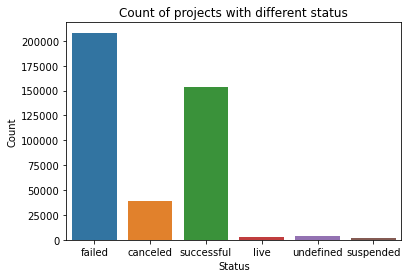

In [168]:
sns.countplot(x = status, data = df_ks)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of projects with different status')

There are three categories 'live', 'undefined', and 'suspended', that don't really give us an insight into the status of the project. So, I am going to drop them. 

In [169]:
df_ks = df_ks.drop(df_ks.loc[df_ks['status']=='live'].index)


In [170]:
df_ks = df_ks.drop(df_ks.loc[df_ks['status']=='undefined'].index)
df_ks = df_ks.drop(df_ks.loc[df_ks['status']=='suspended'].index)


In [171]:
df_ks['status'].unique()

array(['failed', 'canceled', 'successful'], dtype=object)

In [172]:
status1 = df_ks['status'].to_numpy()

Text(0.5, 1.0, 'Count of projects with different status')

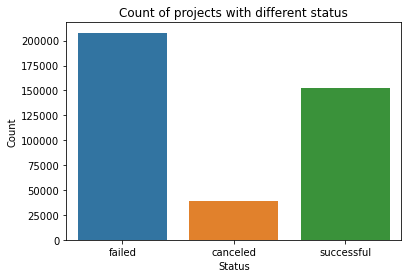

In [173]:
sns.countplot(x = status1, data = df_ks)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of projects with different status')

In [50]:
# labelencoder = LabelEncoder()
# df_ks['status_num'] = labelencoder.fit_transform(df_ks['status'])
# df_ks.head()

,id,name,sub_category,main_category,currency,deadline,launched,status,country,usd_pledged,usd_goal,duration,launched_dt,deadline_dt,launched_year,deadline_year,status_num
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,0.0,1533.95,58,2015-08-11 12:12:28,2015-10-09,2015,2015,1
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,2421.0,30000.00,59,2017-09-02 04:43:57,2017-11-01,2017,2017,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,220.0,45000.00,44,2013-01-12 00:20:50,2013-02-26,2013,2013,1
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,1.0,5000.00,29,2012-03-17 03:24:11,2012-04-16,2012,2012,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,1283.0,19500.00,55,2015-07-04 08:35:03,2015-08-29,2015,2015,0


Next, we will be exploring the explanatory variables one by one. We think that goal amount, pledged amount, duration, country, sub-category, and main-category are likely to determine the success and failure of the kickstarter projects. 

IV_1 = Goal Amount

Text(0, 0.5, 'Count')

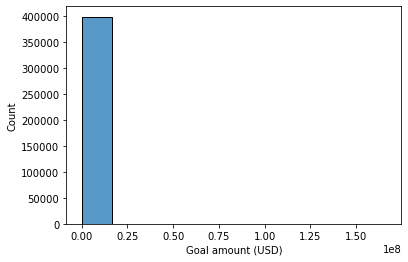

In [174]:
goal = df_ks['usd_goal'].to_numpy()
bin_edges = np.histogram_bin_edges(goal, bins = 10)
sns.histplot(x = df_ks['usd_goal'], data = df_ks, bins = bin_edges)
plt.xlabel('Goal amount (USD)')
plt.ylabel('Count')

In [175]:
df_ks['usd_goal'].min()

0.01

In [176]:
df_ks['usd_goal'].max()

166361390.71

As we can see, the range of the data is quite big, which is skewing the appearance of the histogram. I will now explore some outliers and plot the histogram accordingly. 

In [177]:
len(df_ks[df_ks['usd_goal'] > 300000])

4120

In [178]:
df_ks_sub = df_ks.drop(df_ks.loc[df_ks['usd_goal'] > 300000].index)

Text(0, 0.5, 'Count')

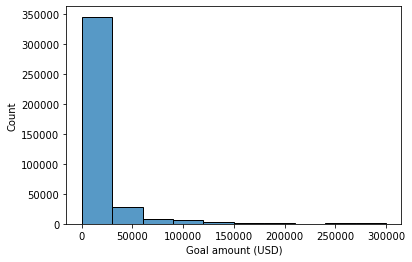

In [179]:
goal_sub = df_ks_sub['usd_goal'].to_numpy()
bin_edges = np.histogram_bin_edges(goal_sub, bins = 10)
sns.histplot(x = df_ks_sub['usd_goal'], data = df_ks_sub, bins = bin_edges)
plt.xlabel('Goal amount (USD)')
plt.ylabel('Count')

Here is an interesting histogram that shows that anything above 300,000 could be outliers. So, we are going to look at the distribution upto 300,000. I have not removed these observations from the analysis. I simply wanted to check the distribution of the data. We see that it is not normally distributed. 

In [180]:
df_ks['usd_goal'].describe()

count    3.994230e+05
mean     4.320570e+04
std      1.089946e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.337000e+03
75%      1.520000e+04
max      1.663614e+08
Name: usd_goal, dtype: float64

The goal amount is largely concentrated towards the lower end of the spectrum, highly skewing the distribution of the data. 

IV_2 = Pledged Amount 

Text(0, 0.5, 'Count')

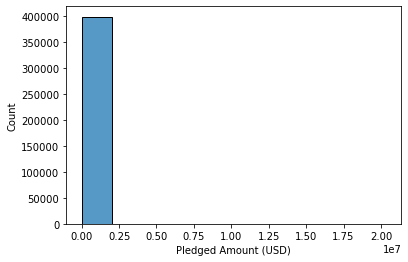

In [181]:
pledged = df_ks['usd_pledged'].to_numpy()
bin_edges = np.histogram_bin_edges(pledged, bins = 10)
sns.histplot(x = df_ks['usd_pledged'], data = df_ks, bins = bin_edges)
plt.xlabel('Pledged Amount (USD)')
plt.ylabel('Count')

Here also we see that some pledged amount seems to be very high, skewing the distribution. 

In [182]:
df_ks['usd_pledged'].min()

0.0

In [183]:
df_ks['usd_pledged'].max()

20338986.27

In [184]:
df_ks['usd_pledged'].describe()

count    3.994230e+05
mean     9.875544e+03
std      9.303078e+04
min      0.000000e+00
25%      4.000000e+01
50%      7.073100e+02
75%      4.390000e+03
max      2.033899e+07
Name: usd_pledged, dtype: float64

In [185]:
len(df_ks[df_ks['usd_pledged'] > 175000])

2996

In [186]:
df_ks_sub1 = df_ks.drop(df_ks.loc[df_ks['usd_pledged'] > 175000].index)

Text(0, 0.5, 'Count')

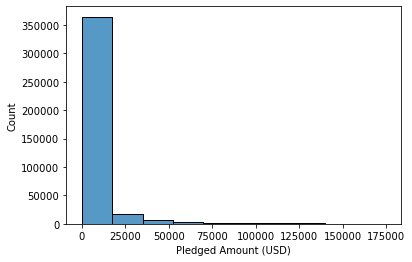

In [187]:
pledged_sub = df_ks_sub1['usd_pledged'].to_numpy()
bin_edges = np.histogram_bin_edges(pledged_sub, bins = 10)
sns.histplot(x = df_ks_sub1['usd_pledged'], data = df_ks_sub1, bins = bin_edges)
plt.xlabel('Pledged Amount (USD)')
plt.ylabel('Count')

The pledged amount is also highly skewed towards the lower end. The histogram shows that this variable is also not normally distributed.

IV_3 = Duration 

Text(0.5, 1.0, 'Ditribution of Duration')

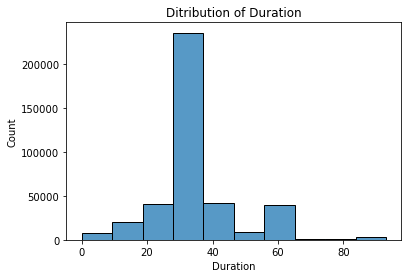

In [188]:
duration = df_ks['duration'].to_numpy()
bin_edges = np.histogram_bin_edges(duration, bins = 10)
sns.histplot(x = df_ks['duration'], data = df_ks, bins = bin_edges)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Ditribution of Duration')

In [189]:
df_ks['duration'].describe()

count    399423.000000
mean         33.073999
std          12.708273
min           0.000000
25%          29.000000
50%          29.000000
75%          36.000000
max          93.000000
Name: duration, dtype: float64

The average duration appears to be 33 days. Duration also seems somewhat skewed towards the lower end. 

IV_4 = Main-Category

In [190]:
df_ks['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism', 'games', 'comics',
       'film & video', 'design', 'crafts', 'technology', 'music',
       'fashion', 'publishing', 'art', 'food', 'theater', 'dance',
       'photography', 'journalism'], dtype=object)

In [191]:
df_ks = df_ks.replace(['publishing'], 'Publishing')

In [69]:
df_ks = df_ks.replace(['film & video'], 'Film & Video')
df_ks = df_ks.replace(['music'], 'Music')
df_ks = df_ks.replace(['food'], 'Food')
df_ks = df_ks.replace(['design'], 'Design')
df_ks = df_ks.replace(['crafts'], 'Crafts')
df_ks = df_ks.replace(['technology'], 'Technology')
df_ks = df_ks.replace(['dance'], 'Dance')
df_ks = df_ks.replace(['journalism'], 'Journalism')
df_ks = df_ks.replace(['games'], 'Games')
df_ks = df_ks.replace(['comics'], 'Comics')
df_ks = df_ks.replace(['art'], 'Art')
df_ks = df_ks.replace(['photography'], 'Photography')
df_ks = df_ks.replace(['theater'], 'Theater')
df_ks = df_ks.replace(['fashion'], 'Fashion')

In [193]:
df_ks['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism', 'games', 'comics',
       'film & video', 'design', 'crafts', 'technology', 'music',
       'fashion', 'art', 'food', 'theater', 'dance', 'photography',
       'journalism'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 [Text(0, 0, 'Publishing'),
  Text(1, 0, 'Film & Video'),
  Text(2, 0, 'Music'),
  Text(3, 0, 'Food'),
  Text(4, 0, 'Design'),
  Text(5, 0, 'Crafts'),
  Text(6, 0, 'Games'),
  Text(7, 0, 'Comics'),
  Text(8, 0, 'Fashion'),
  Text(9, 0, 'Theater'),
  Text(10, 0, 'Art'),
  Text(11, 0, 'Photography'),
  Text(12, 0, 'Technology'),
  Text(13, 0, 'Dance'),
  Text(14, 0, 'Journalism'),
  Text(15, 0, 'games'),
  Text(16, 0, 'comics'),
  Text(17, 0, 'film & video'),
  Text(18, 0, 'design'),
  Text(19, 0, 'crafts'),
  Text(20, 0, 'technology'),
  Text(21, 0, 'music'),
  Text(22, 0, 'fashion'),
  Text(23, 0, 'art'),
  Text(24, 0, 'food'),
  Text(25, 0, 'theater'),
  Text(26, 0, 'dance'),
  Text(27, 0, 'photography'),
  Text(28, 0, 'journalism')])

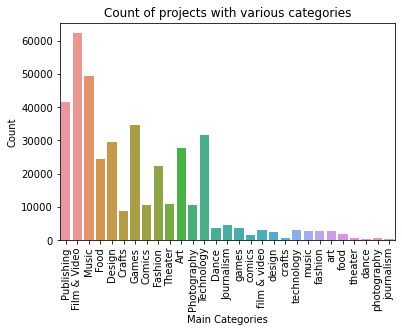

In [194]:
sns.countplot(x = df_ks['main_category'], data = df_ks)
plt.xlabel('Main Categories')
plt.ylabel('Count')
plt.title('Count of projects with various categories')
plt.xticks(rotation=90)

In [72]:
# labelencoder = LabelEncoder()
# df_ks['category_num'] = labelencoder.fit_transform(df_ks['main_category'])
# df_ks.head()

IV_5 = Country

In [195]:
df_ks['country'].unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'LU', 'SG', 'N,0"',
       'JP'], dtype=object)

In [196]:
df_ks.shape

(399423, 16)

In [197]:
df_ks[df_ks['country'] == 'N,0"']

,id,name,sub_category,main_category,currency,deadline,launched,status,country,usd_pledged,usd_goal,duration,launched_dt,deadline_dt,launched_year,deadline_year
2457,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,2016-04-26 19:46:26,successful,"N,0""",5170.00,5000.00,29,2016-04-26 19:46:26,2016-05-26,2016,2016
4338,1022254171,Help OrphanSporks Record Our Fourth Album!,Music,Music,USD,2016-05-14,2016-04-11 07:20:59,canceled,"N,0""",1375.00,2500.00,32,2016-04-11 07:20:59,2016-05-14,2016,2016
4892,1024989802,Jackson Ruby: The Cassette Album,Music,Music,USD,2016-05-11,2016-04-11 19:29:17,successful,"N,0""",5296.00,5000.00,29,2016-04-11 19:29:17,2016-05-11,2016,2016
5353,1027275369,Help Parker Brown make his first solo album,Music,Music,USD,2016-05-21,2016-04-21 16:14:28,successful,"N,0""",5077.00,3800.00,29,2016-04-21 16:14:28,2016-05-21,2016,2016
5597,1028691308,Help BETHANY record a NEW single in Nash!,Music,Music,USD,2016-05-08,2016-04-04 23:32:00,successful,"N,0""",3502.13,3500.00,33,2016-04-04 23:32:00,2016-05-08,2016,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368889,949401487,A Taste of San Diego's Singer Songwriters,Music,Music,USD,2016-05-09,2016-04-09 02:21:45,failed,"N,0""",1408.00,7500.00,29,2016-04-09 02:21:45,2016-05-09,2016,2016
371387,962477474,Spoken Fruit Magazine,Print,Journalism,EUR,2016-04-28,2016-03-29 16:02:57,failed,"N,0""",2204.21,17104.54,29,2016-03-29 16:02:57,2016-04-28,2016,2016
372375,967557880,Help Danelle Finish Her First EP Album,Music,Music,USD,2016-04-28,2016-04-05 18:56:21,successful,"N,0""",3686.00,3500.00,22,2016-04-05 18:56:21,2016-04-28,2016,2016
375359,982919439,Faith,Film & Video,Film & Video,USD,2016-05-06,2016-03-07 04:17:33,failed,"N,0""",2.00,9000.00,59,2016-03-07 04:17:33,2016-05-06,2016,2016


In [198]:
# df = df_ks[df_ks.country != 'N,0"']
# df = df.reset_index(drop=True)

df_ks = df_ks.drop(df_ks.loc[df_ks['country']=='N,0"'].index)


In [199]:
df_ks['country'].unique()


array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE',
       'FR', 'NL', 'NZ', 'CH', 'AT', 'BE', 'DK', 'HK', 'LU', 'SG', 'JP'],
      dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'GB'),
  Text(1, 0, 'US'),
  Text(2, 0, 'CA'),
  Text(3, 0, 'AU'),
  Text(4, 0, 'NO'),
  Text(5, 0, 'IT'),
  Text(6, 0, 'DE'),
  Text(7, 0, 'IE'),
  Text(8, 0, 'MX'),
  Text(9, 0, 'ES'),
  Text(10, 0, 'SE'),
  Text(11, 0, 'FR'),
  Text(12, 0, 'NL'),
  Text(13, 0, 'NZ'),
  Text(14, 0, 'CH'),
  Text(15, 0, 'AT'),
  Text(16, 0, 'BE'),
  Text(17, 0, 'DK'),
  Text(18, 0, 'HK'),
  Text(19, 0, 'LU'),
  Text(20, 0, 'SG'),
  Text(21, 0, 'JP')])

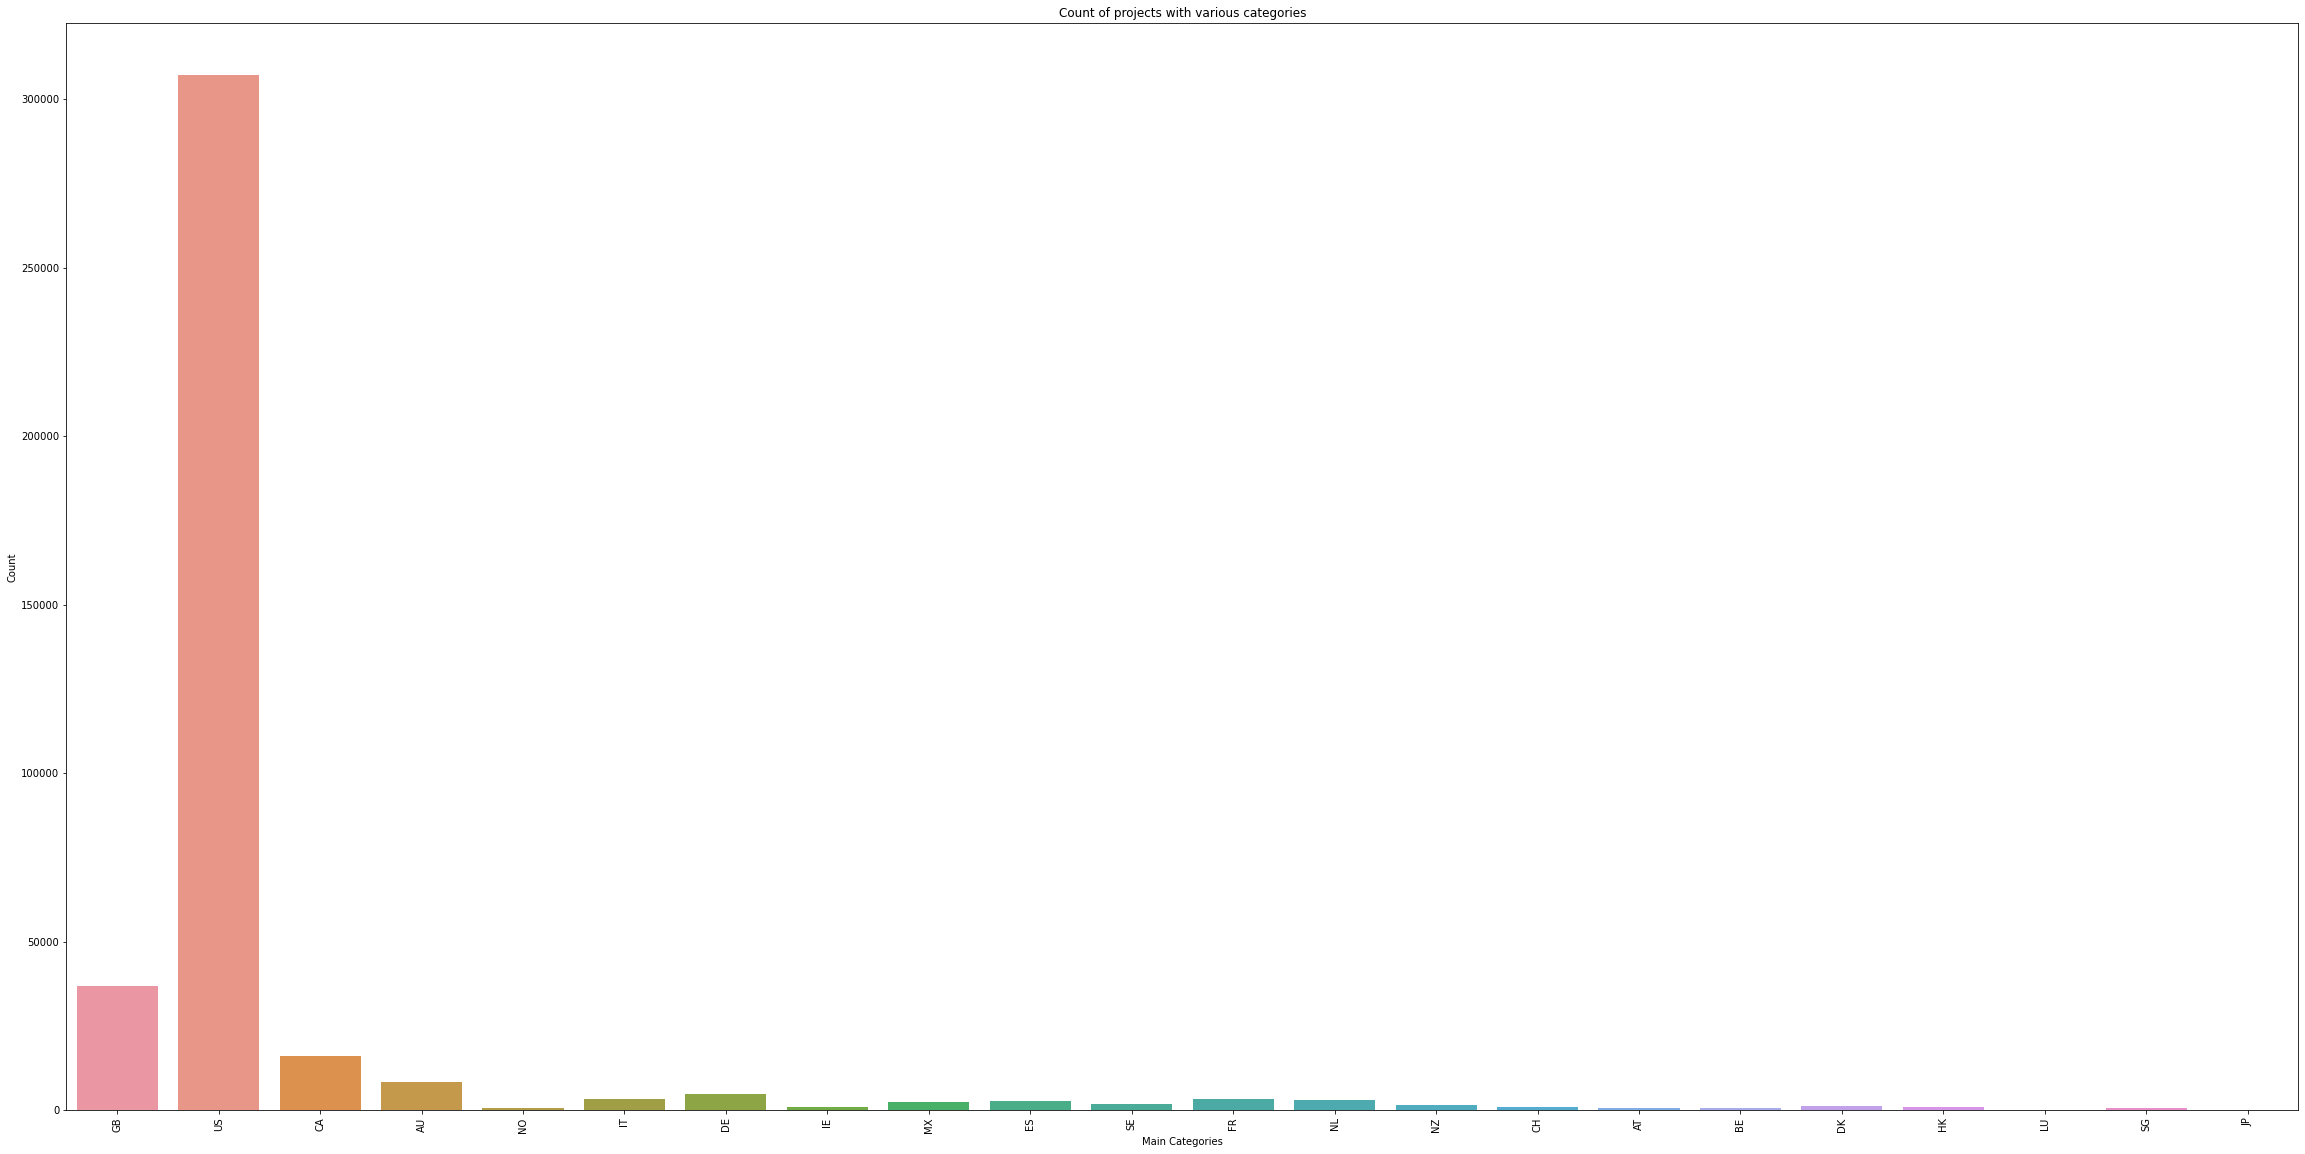

In [200]:
plt.figure(figsize= (40,20))
sns.countplot(x = df_ks['country'], data = df_ks)
plt.xlabel('Main Categories')
plt.ylabel('Count')
plt.title('Count of projects with various categories')
plt.xticks(rotation=90)

In [79]:
# labelencoder = LabelEncoder()
# df_ks['country_num'] = labelencoder.fit_transform(df_ks['country'])
# df_ks.head()

Next, I want to check whether the variables are correlated. For this, I am going to use a heatmap. 

<AxesSubplot:>

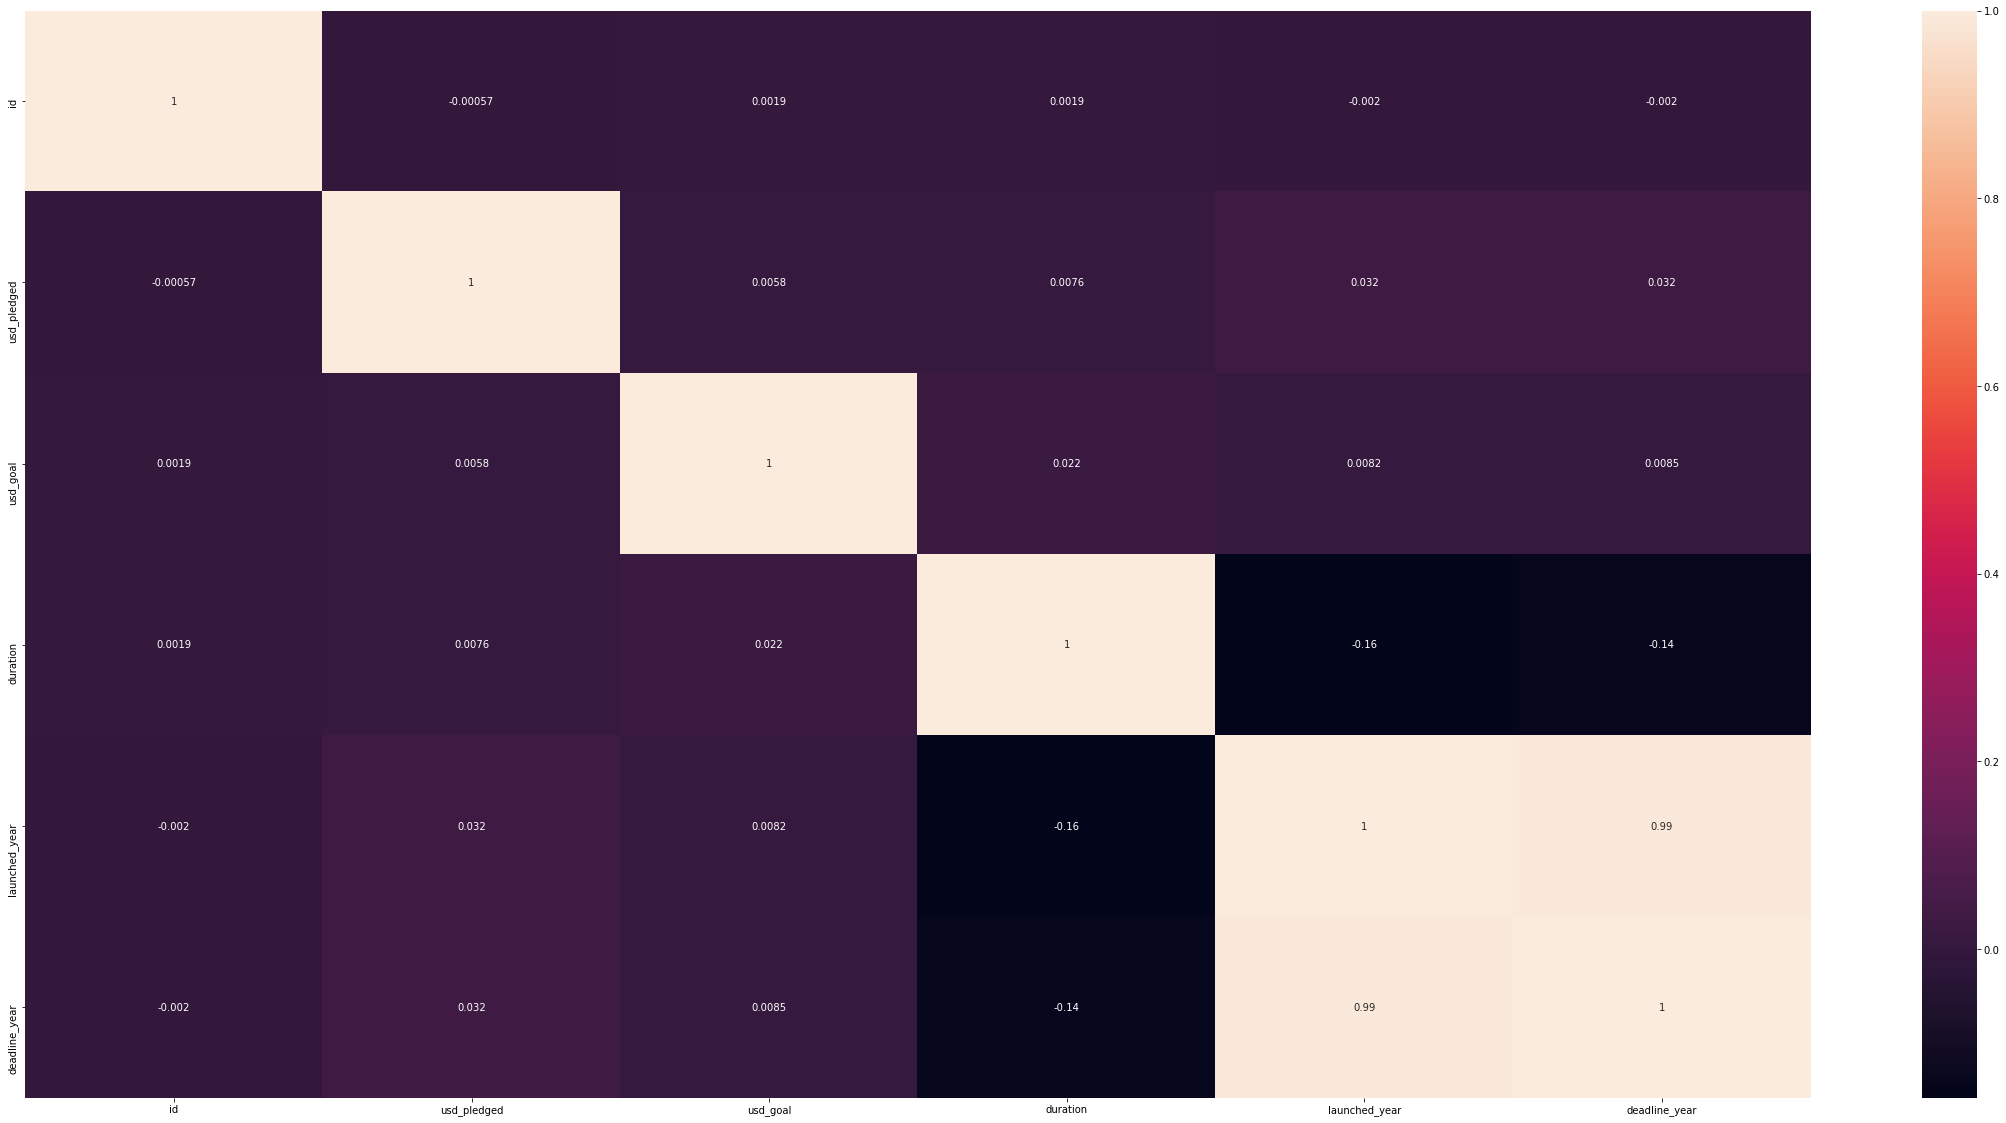

In [201]:
plt.figure(figsize= (40,20))
sns.heatmap(df_ks.corr(), annot=True)


The heatmap shows us several interesting relationships. 
a. First, our independent variables of interest are not highly correlated to one another. 
b. Status (DV) maybe correlated with the pledged amount (usd_pledged) and with the country variable. The correlation might be better with the pledged amount. 
c. Status does not seem to be correlated with duration.
d. The correlation between status and the goal amount appears to be very weak. 

## Visualizing relationships

### Relationship 1: X= Goal Amount, Y = Status

Text(0.5, 1.0, 'Relationship between goal amount and the status of the project')

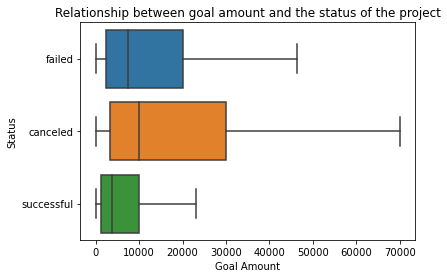

In [202]:
sns.boxplot(x= 'usd_goal', y= 'status', data = df_ks, showfliers=False)
plt.xlabel('Goal Amount')
plt.ylabel('Status')
plt.title('Relationship between goal amount and the status of the project')

The above boxplot gives a clearer picture. The picture shows that the median goal amount of successful projects is less than the median goal amount of canceled or failed projects. This indicates that with higher goal amount, there is more chances of canceled or failed projects. 

## Relationship 2: X= Pledged Amount, Y = Status

Text(0.5, 1.0, 'Relationship between pledged amount and the status of the project')

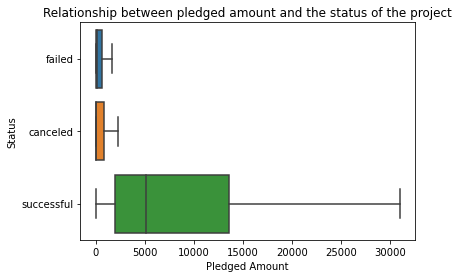

In [203]:
#sns.set(style="whitegrid")
sns.boxplot(x= 'usd_pledged', y= 'status', data = df_ks, showfliers=False)
plt.xlabel('Pledged Amount')
plt.ylabel('Status')
plt.title('Relationship between pledged amount and the status of the project')

The above boxplot shows that the median pledged amount of successful projects are a lot higher than the median pledged amount of failed or canceled projects. This indicates that success of projects are likely to be determined by higher pledged amounts. 

### Relationship 3: X = Duration, Y = Status

Text(0.5, 1.0, 'Relationship between duration and the status of the project')

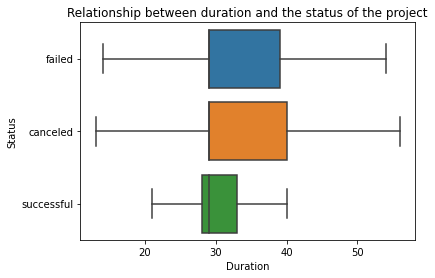

In [204]:
sns.boxplot(x= 'duration', y= 'status', data = df_ks, showfliers=False)
plt.xlabel('Duration')
plt.ylabel('Status')
plt.title('Relationship between duration and the status of the project')

In [205]:
df_ks[df_ks['status'] == 'successful']['duration'].describe()

count    152605.000000
mean         31.014744
std          11.602927
min           0.000000
25%          28.000000
50%          29.000000
75%          33.000000
max          93.000000
Name: duration, dtype: float64

In [206]:
df_ks[df_ks['status'] == 'failed']['duration'].describe()

count    207812.000000
mean         34.230521
std          13.174921
min           0.000000
25%          29.000000
50%          29.000000
75%          39.000000
max          91.000000
Name: duration, dtype: float64

In [207]:
df_ks[df_ks['status'] == 'failed']['duration'].describe()

count    207812.000000
mean         34.230521
std          13.174921
min           0.000000
25%          29.000000
50%          29.000000
75%          39.000000
max          91.000000
Name: duration, dtype: float64

We see that for the canceled and failed status, the 25th and the 50th percentile is the same. The median of the successful projects is not different than that of the failed and canceled project, indicating that duration of the project may not be correlated with the status of the project. 

### Relationship 4: X = Main_category, Y = Status

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

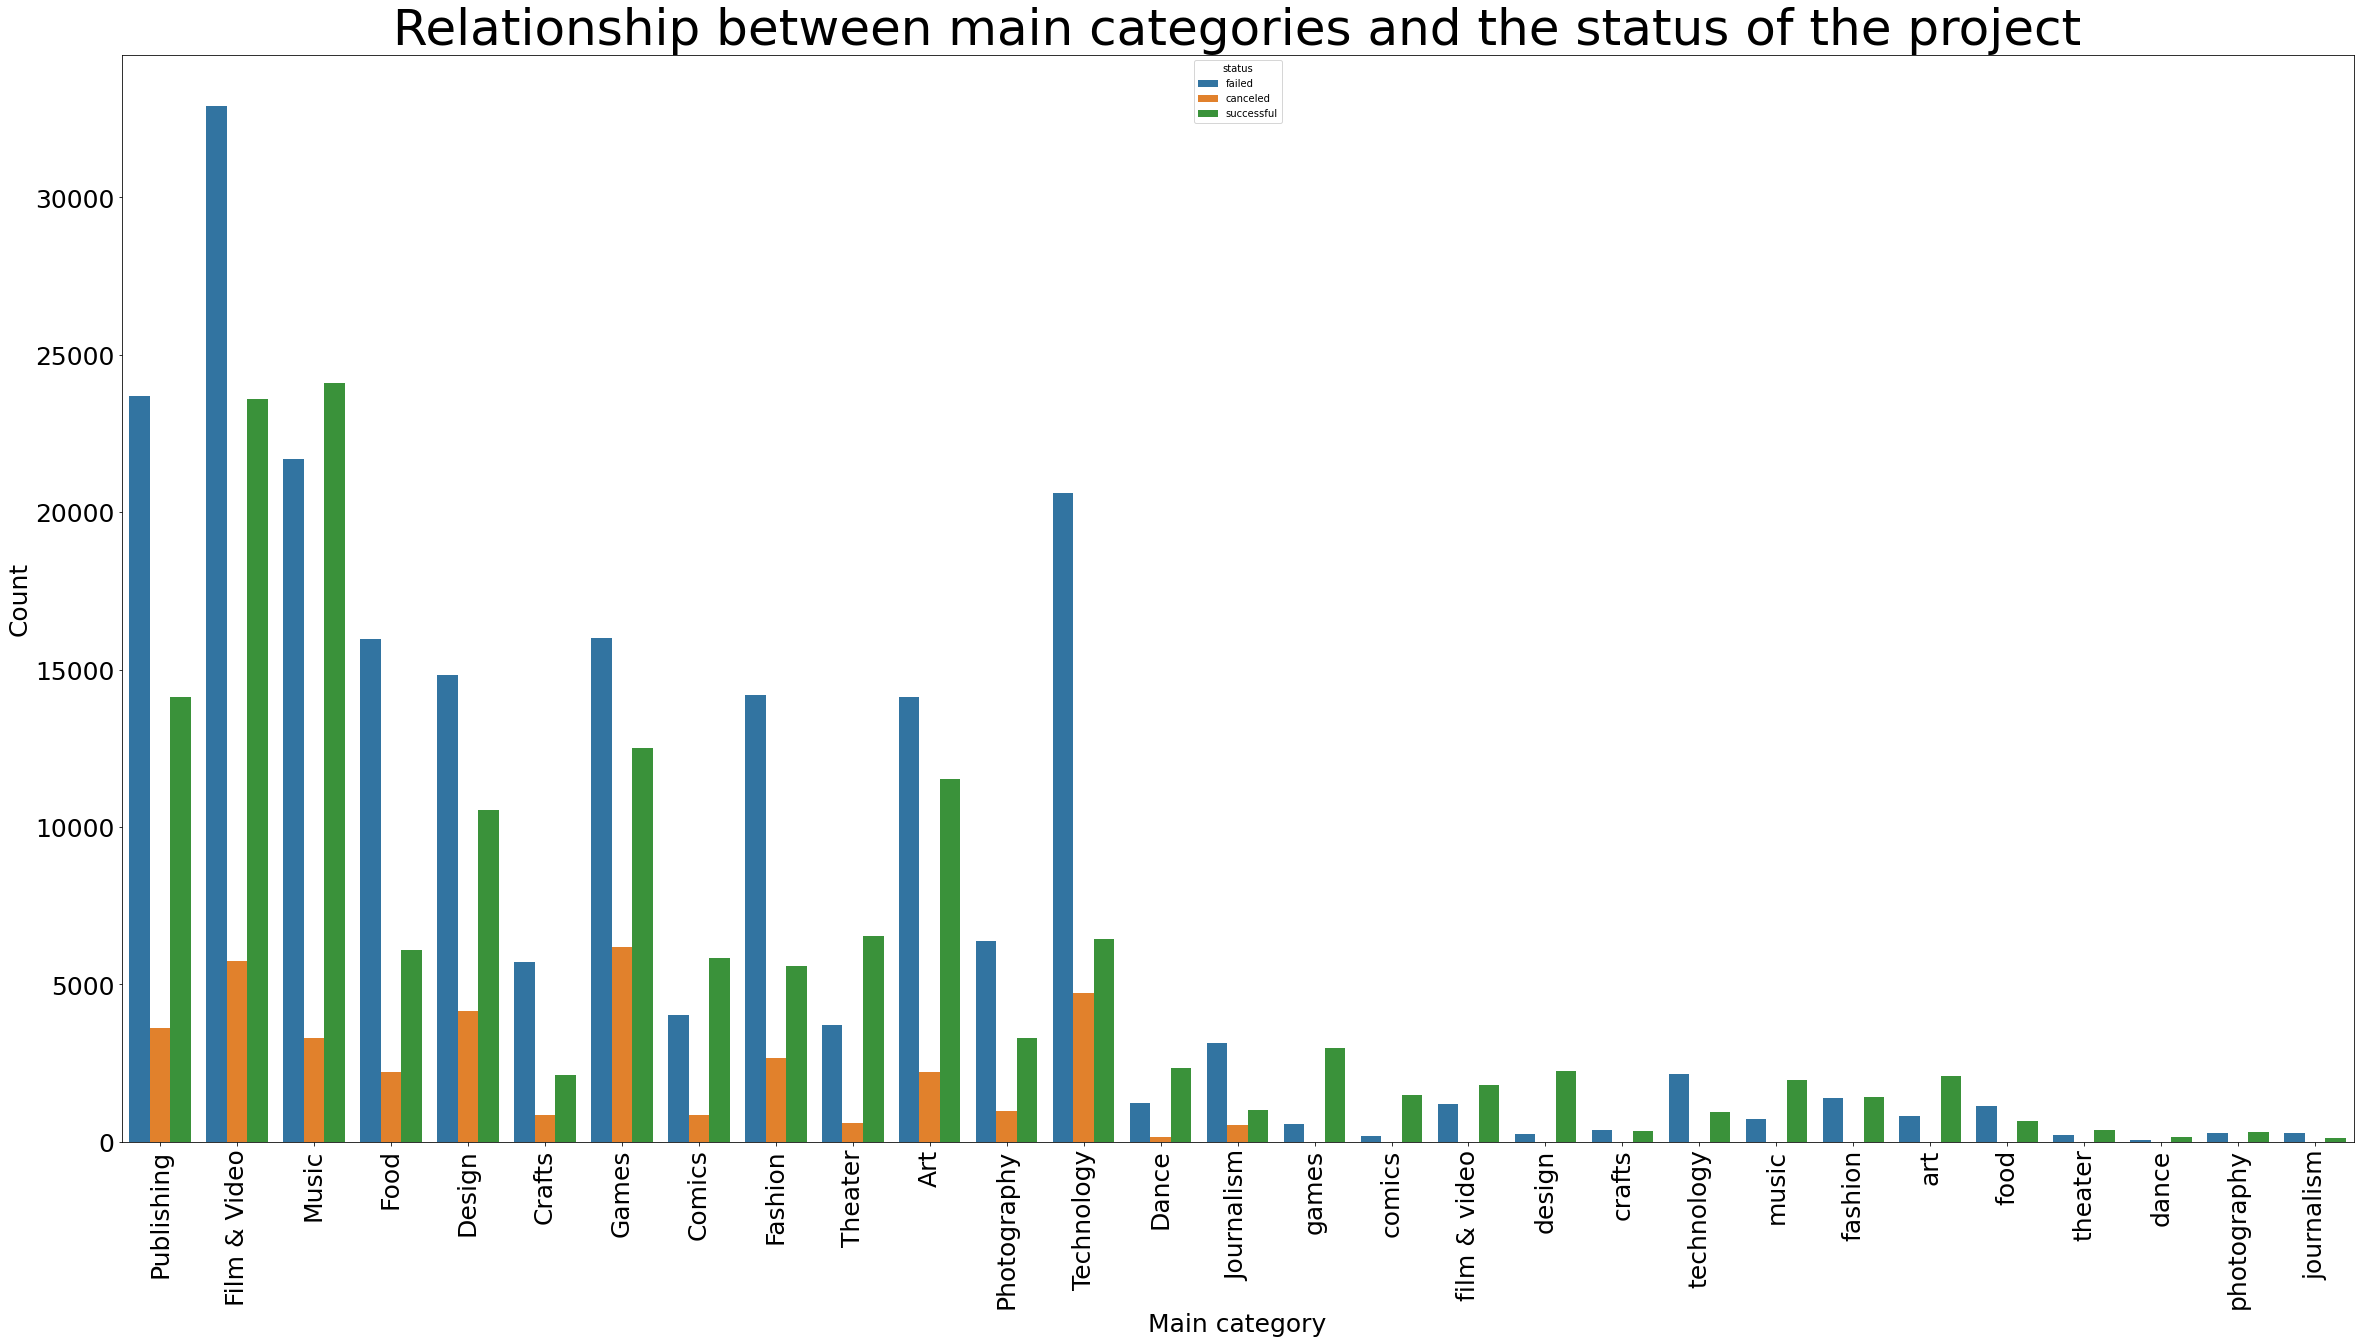

In [208]:
plt.figure(figsize= (40,20))
sns.countplot(x = 'main_category', hue = 'status', data = df_ks)
plt.xlabel('Main category', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.title('Relationship between main categories and the status of the project', fontsize = 50)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize = 25)



The above countplot shows that categories may not be the best indicator of success or failure as almost every category has more canceled projects than either two categories and every category has more successful projects than failed ones. ** Ask about grouping it further here.**

### Relationship 5: X = Country, Y = Status

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000., 180000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

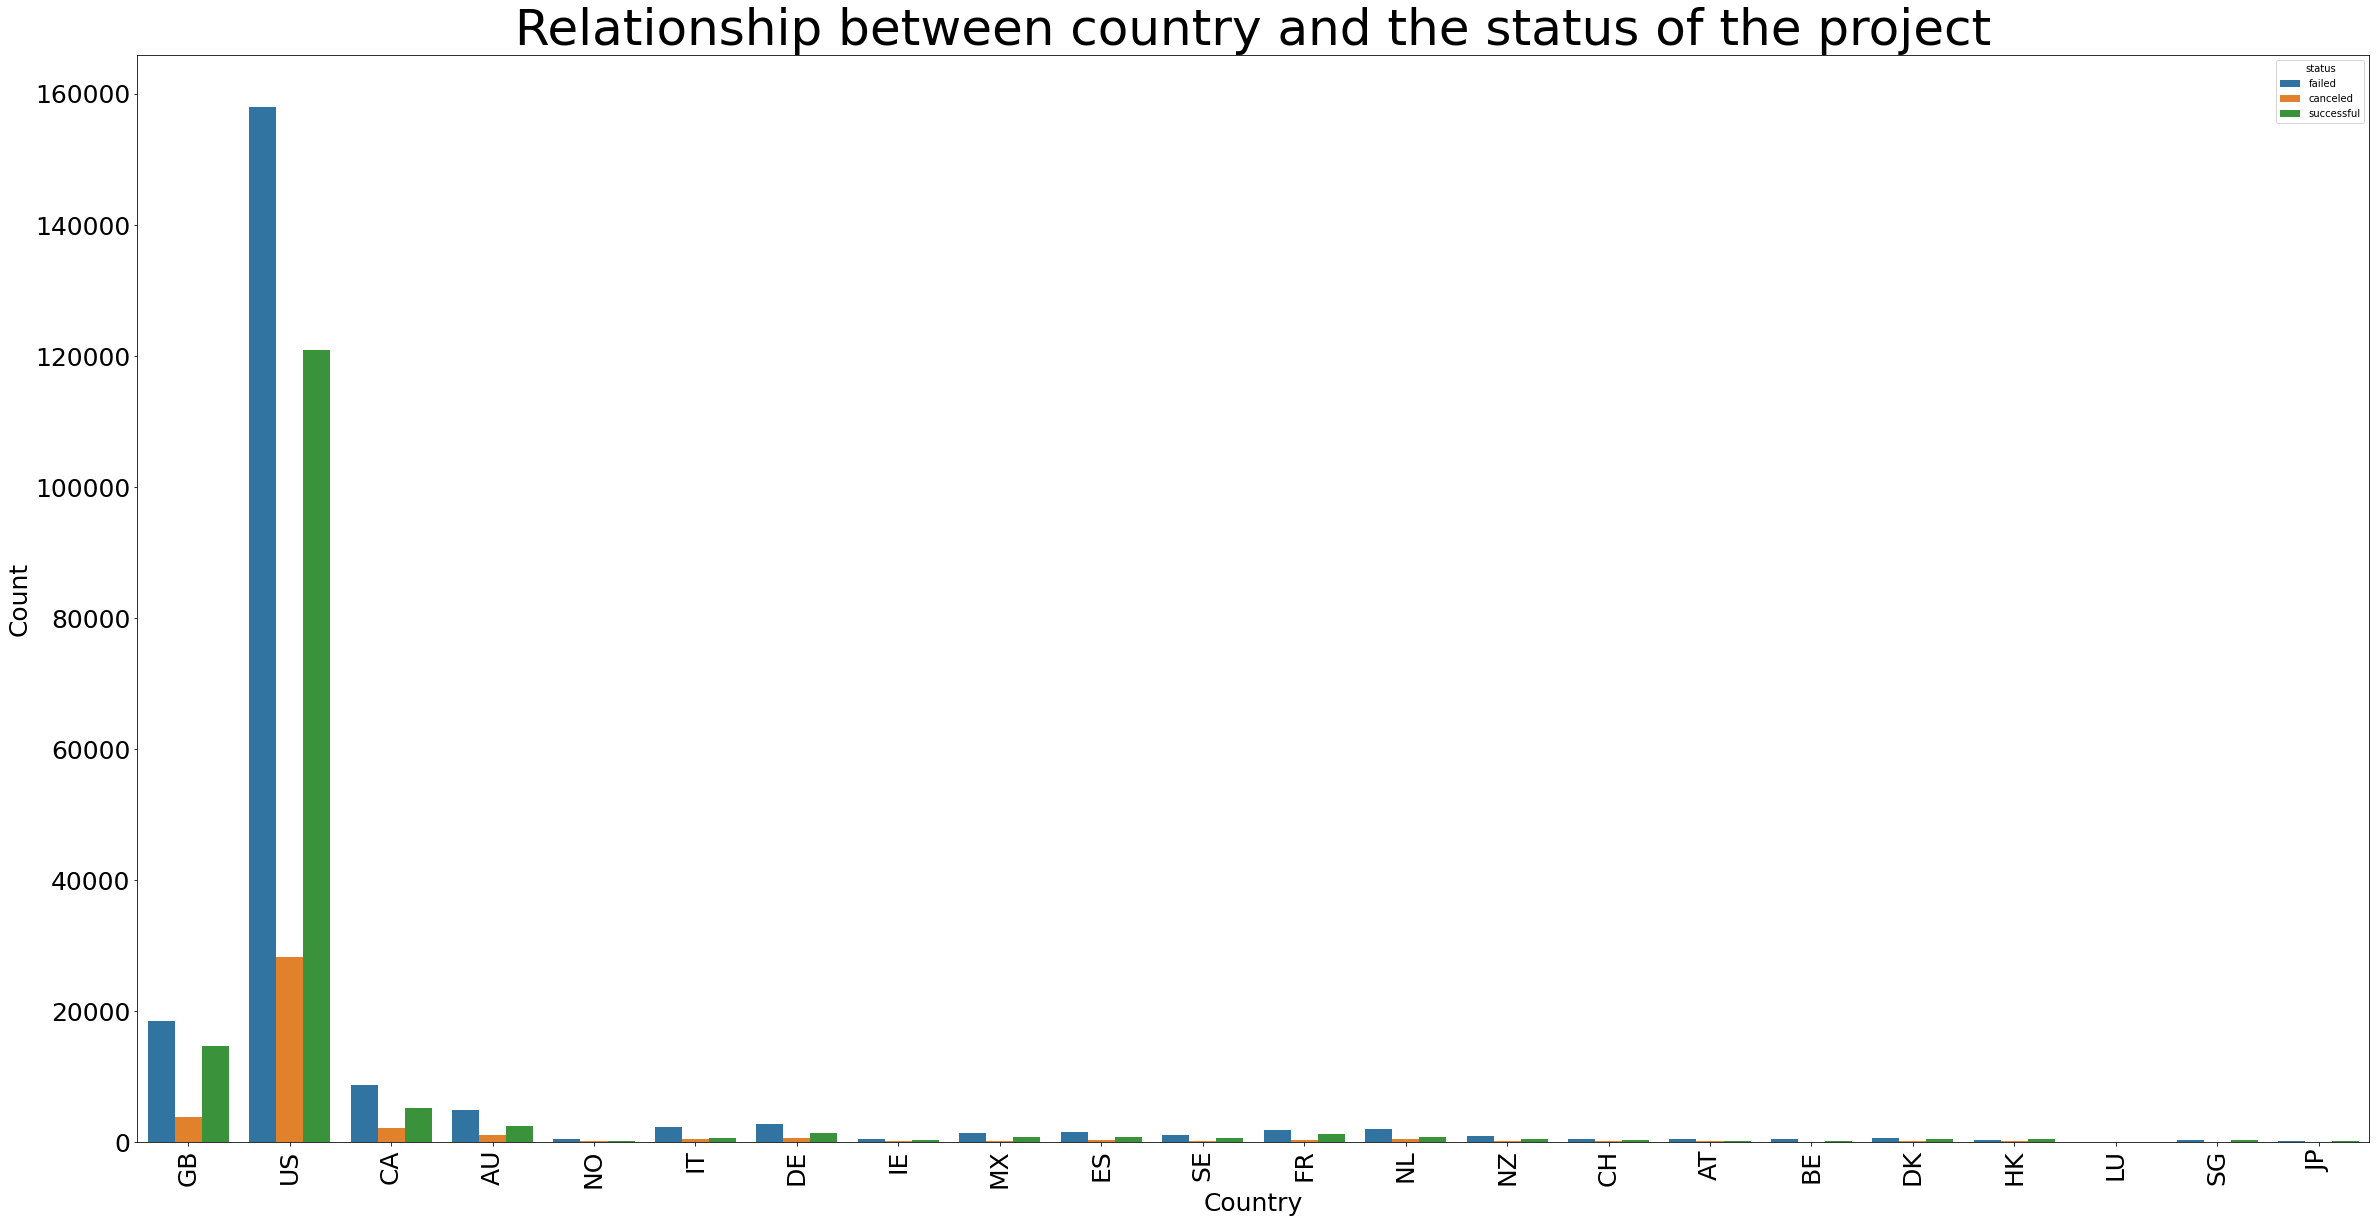

In [209]:
plt.figure(figsize= (40,20))
sns.countplot(x = 'country', hue = 'status', data = df_ks)
plt.xlabel('Country', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.title('Relationship between country and the status of the project', fontsize = 50)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize = 25)



It does not look like countries determine the status of the project as all countries listed have canceled, successful, and failed projects in that respective order. 

We want to see whether plotting the pledged amount, which could potentially contribute in the determination of project status (as shown by the boxplot above), against other variables gives some insight into the correlation between variables. 

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

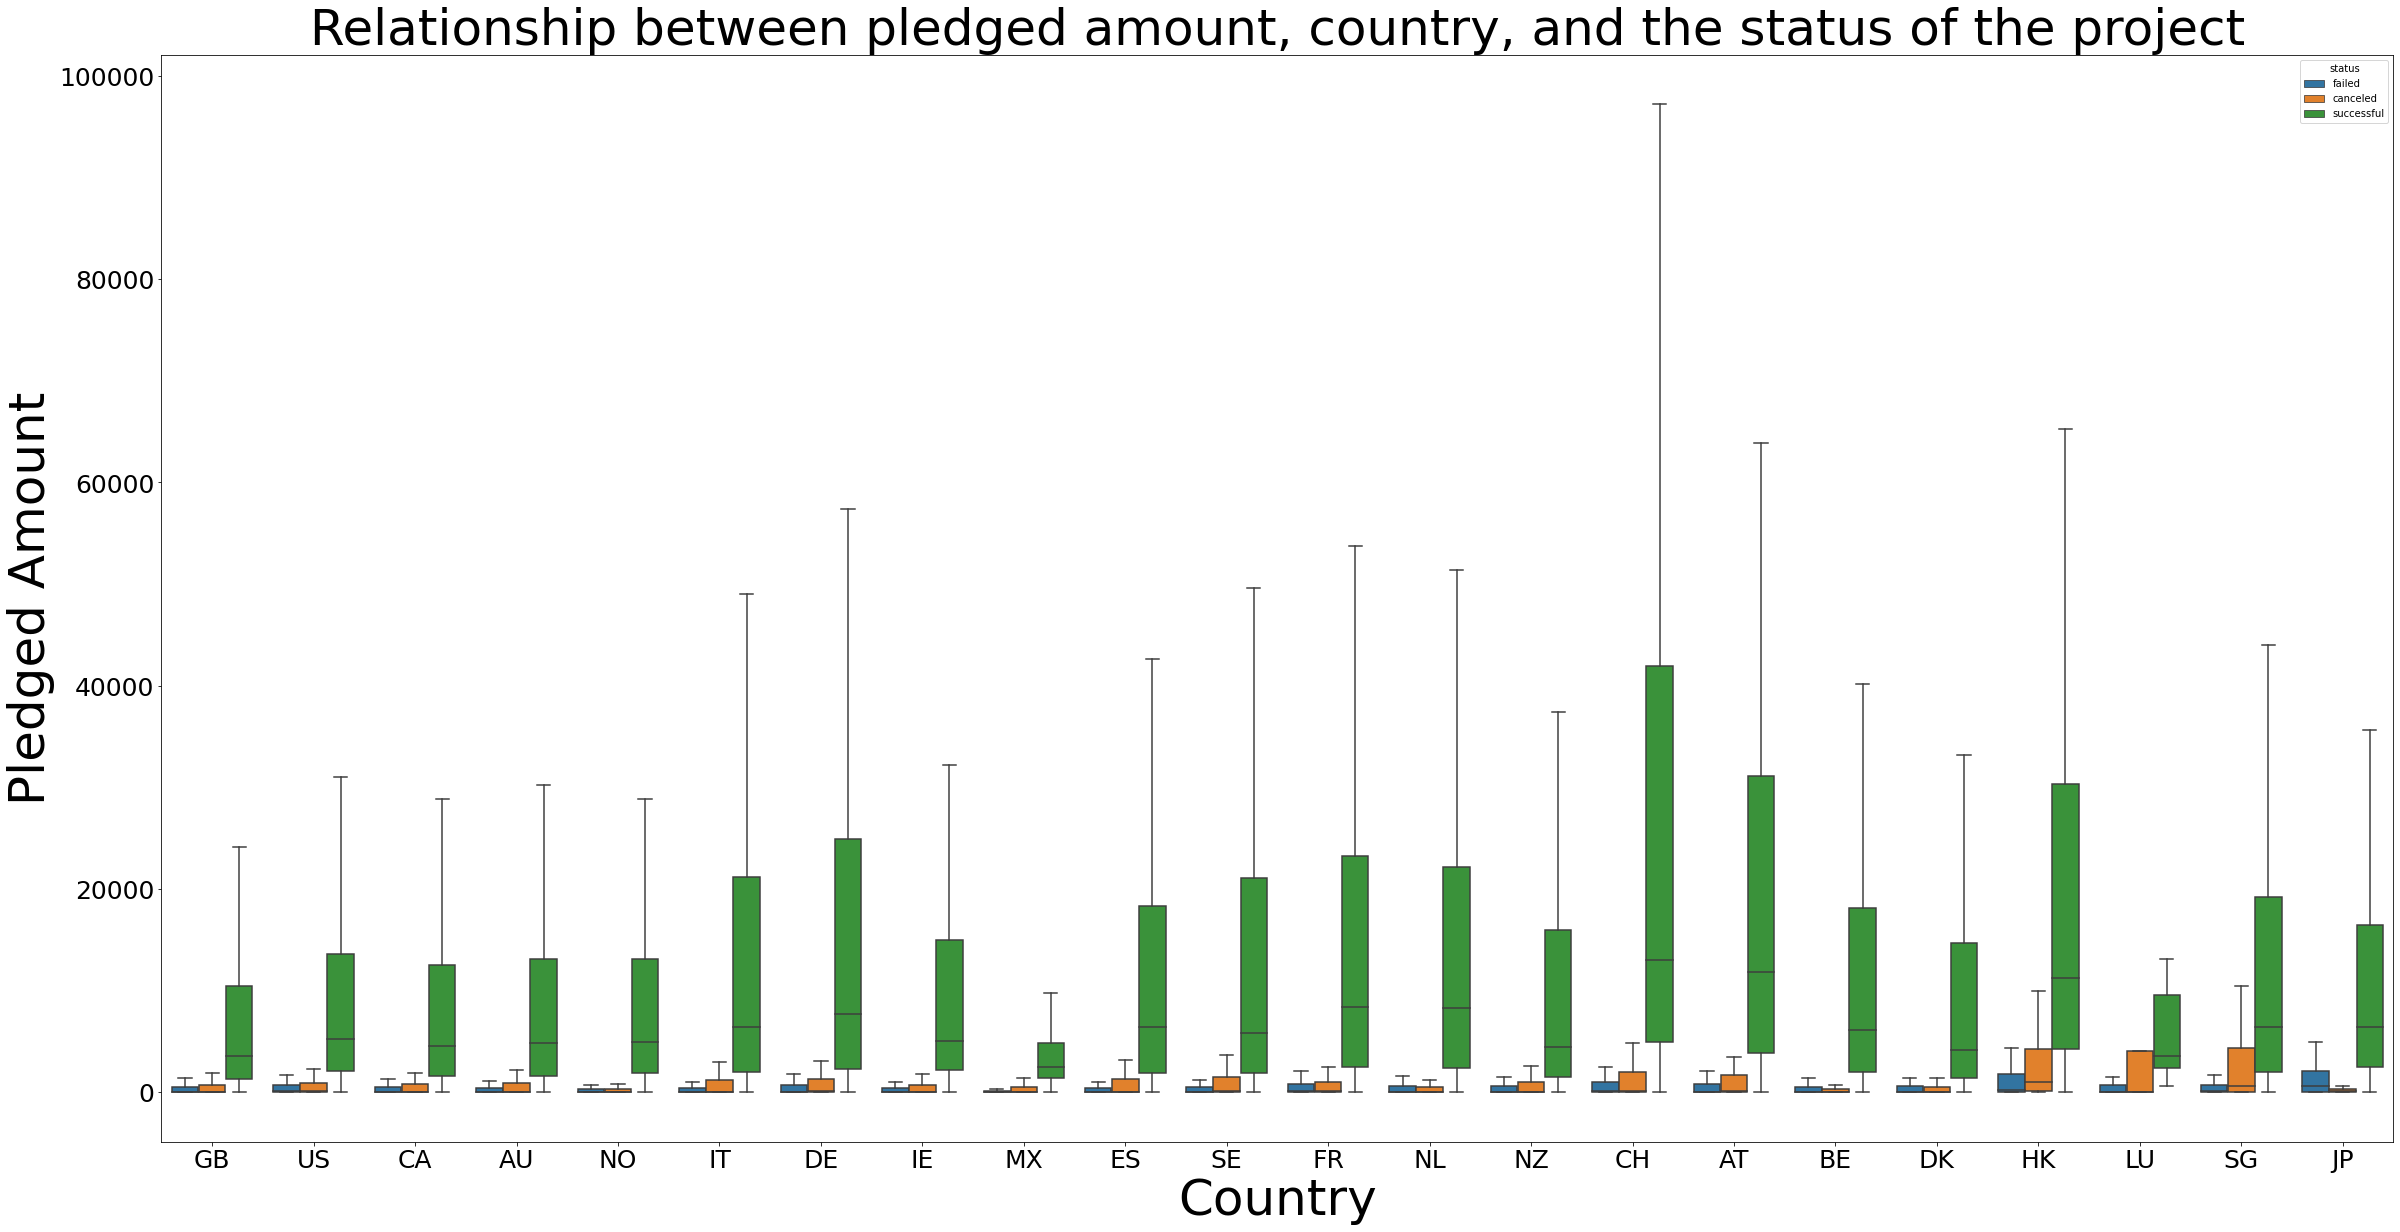

In [210]:
plt.figure(figsize= (40,20))
sns.boxplot(x= 'country', y= 'usd_pledged', hue= 'status', data = df_ks, showfliers = False)
plt.xlabel('Country', fontsize = 50)
plt.ylabel('Pledged Amount', fontsize = 50)
plt.title('Relationship between pledged amount, country, and the status of the project', fontsize = 50)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

(array([-25000.,      0.,  25000.,  50000.,  75000., 100000., 125000.,
        150000., 175000., 200000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

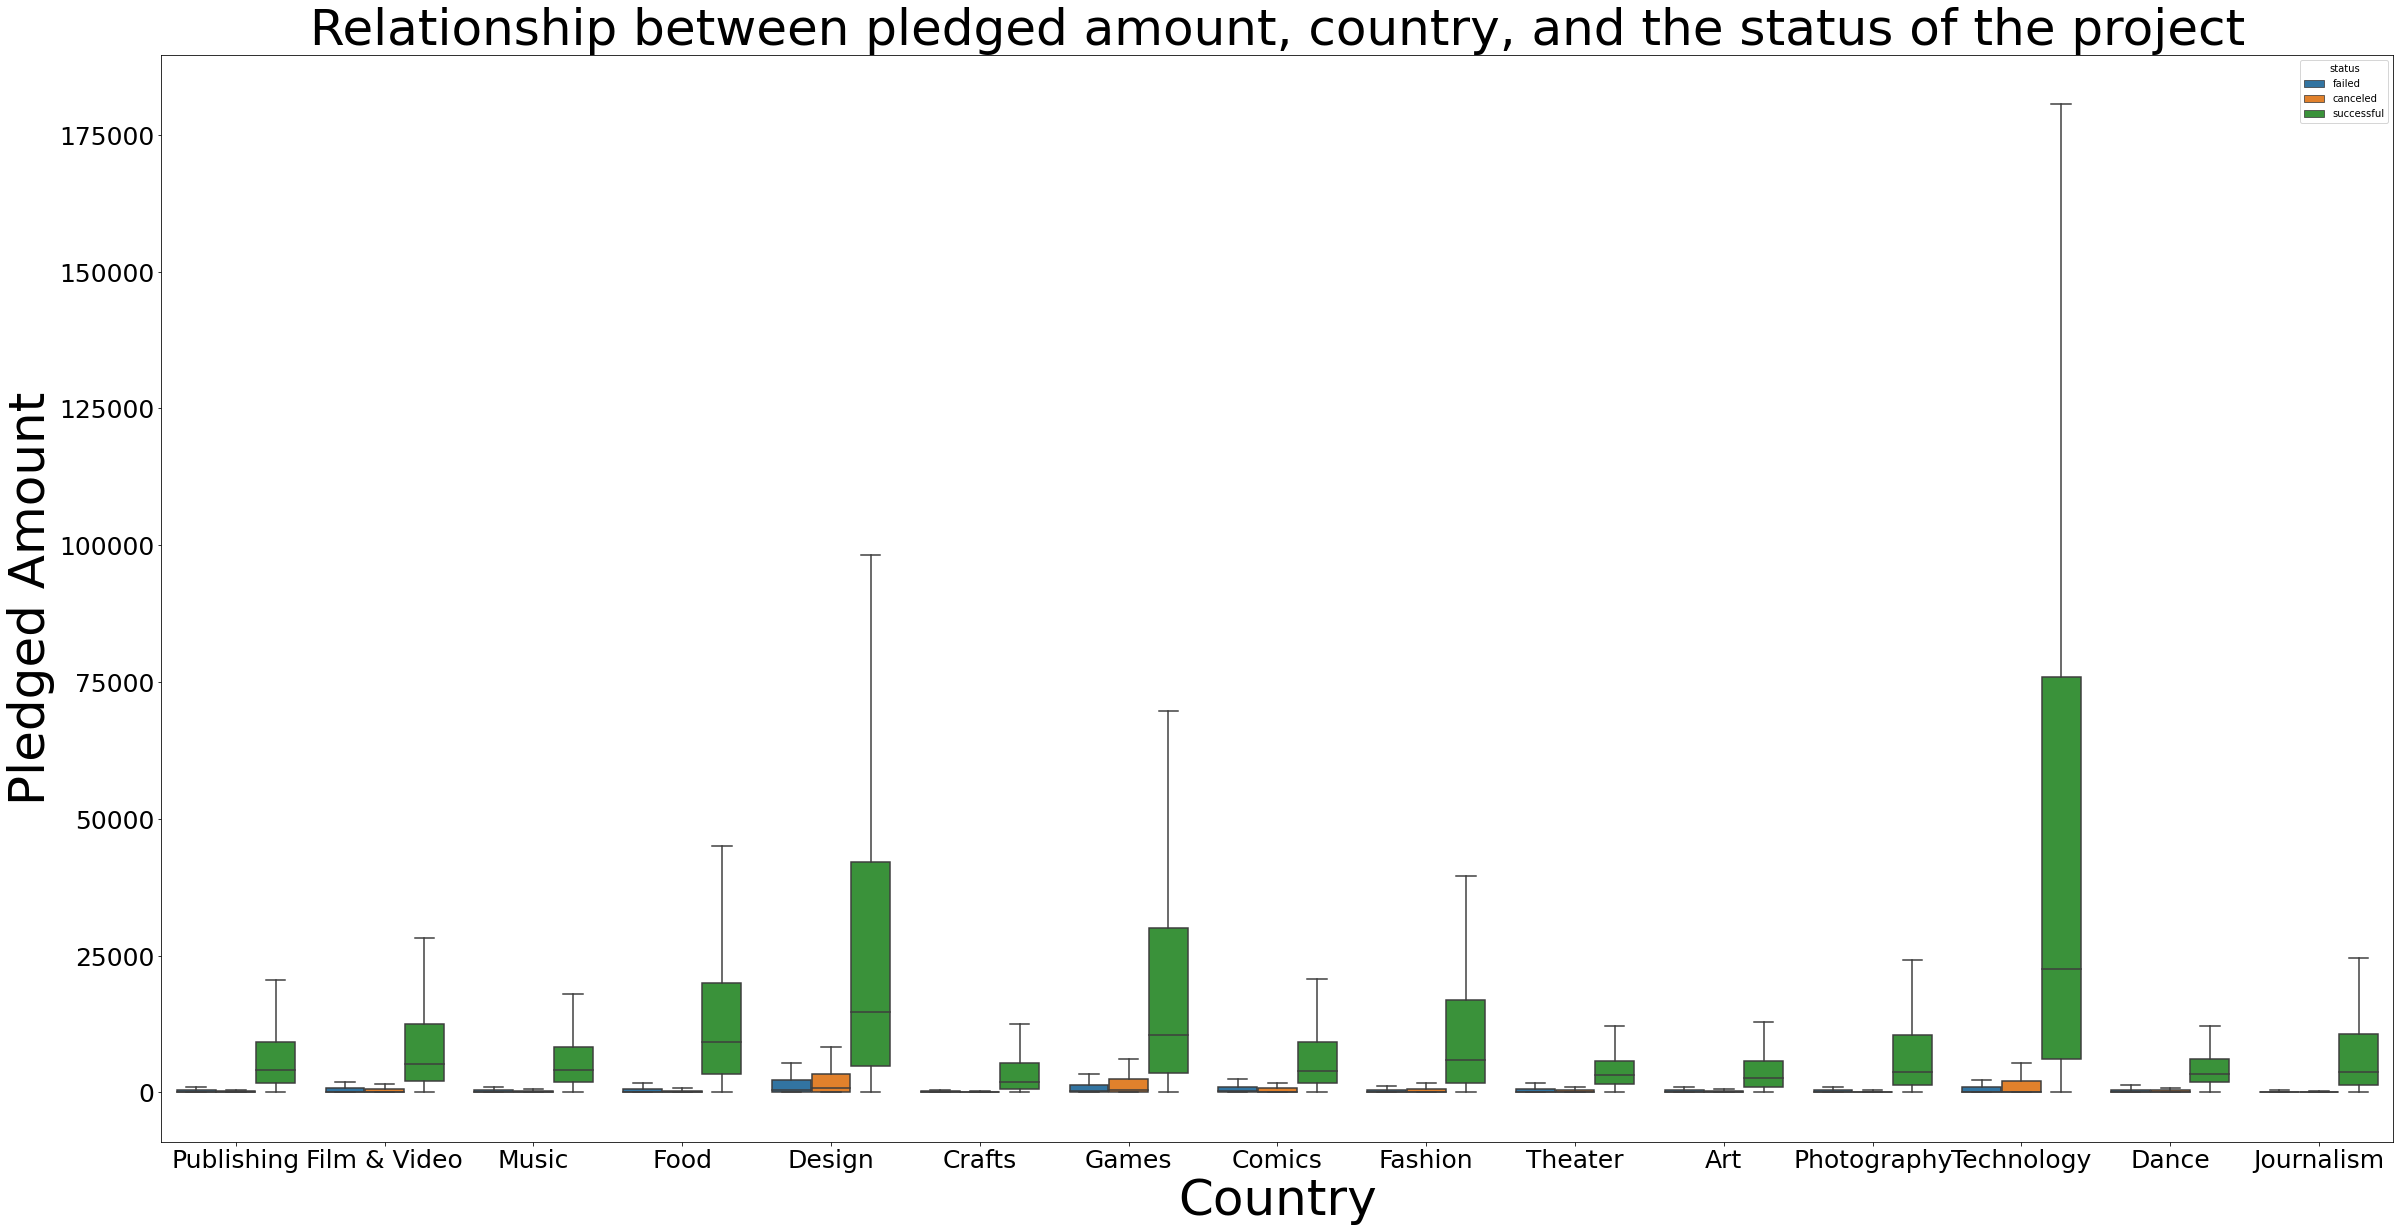

In [90]:
plt.figure(figsize= (40,20))
sns.boxplot(x= 'main_category', y= 'usd_pledged', hue= 'status', data = df_ks, showfliers = False)
plt.xlabel('Country', fontsize = 50)
plt.ylabel('Pledged Amount', fontsize = 50)
plt.title('Relationship between pledged amount, country, and the status of the project', fontsize = 50)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

Looking at these two boxplots, we see that for every country the median of the successful projects are higher as the pledged amount increases. Similarly, we also find that for every category the median of the successful projects are higher as the pledged amount increases. This could indicate that there is a correlation between pledged amount and success of the projects. 

We want to explore the same correlation for the goal amount as well. 

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000., 140000., 160000., 180000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

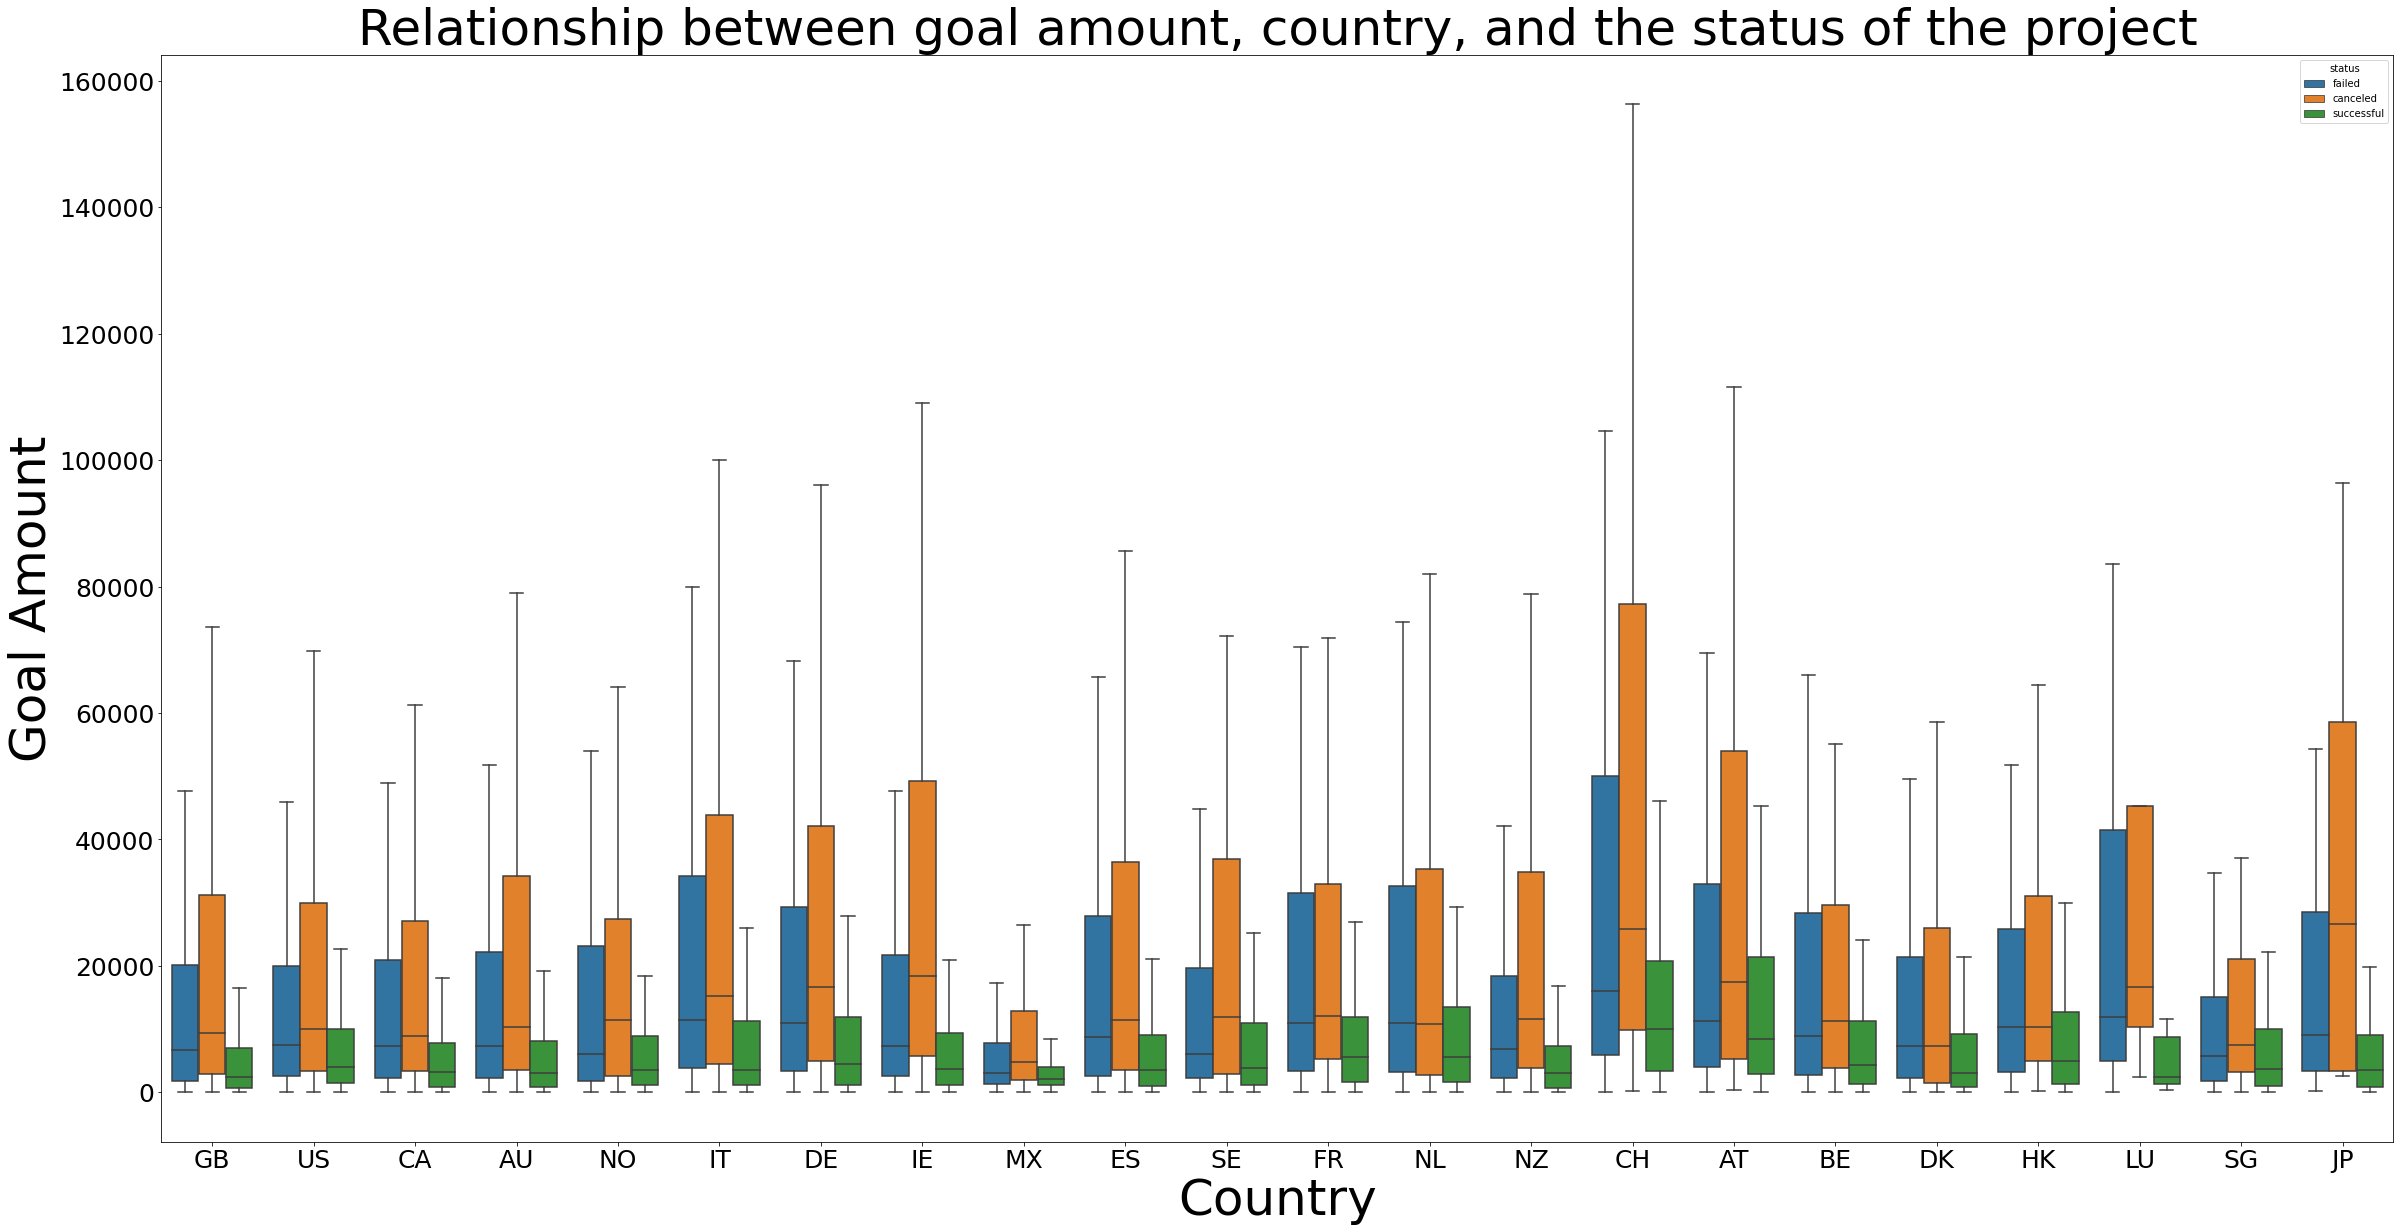

In [211]:
plt.figure(figsize= (40,20))
sns.boxplot(x= 'country', y= 'usd_goal', hue= 'status', data = df_ks, showfliers = False)
plt.xlabel('Country', fontsize = 50)
plt.ylabel('Goal Amount', fontsize = 50)
plt.title('Relationship between goal amount, country, and the status of the project', fontsize = 50)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

(array([-25000.,      0.,  25000.,  50000.,  75000., 100000., 125000.,
        150000., 175000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

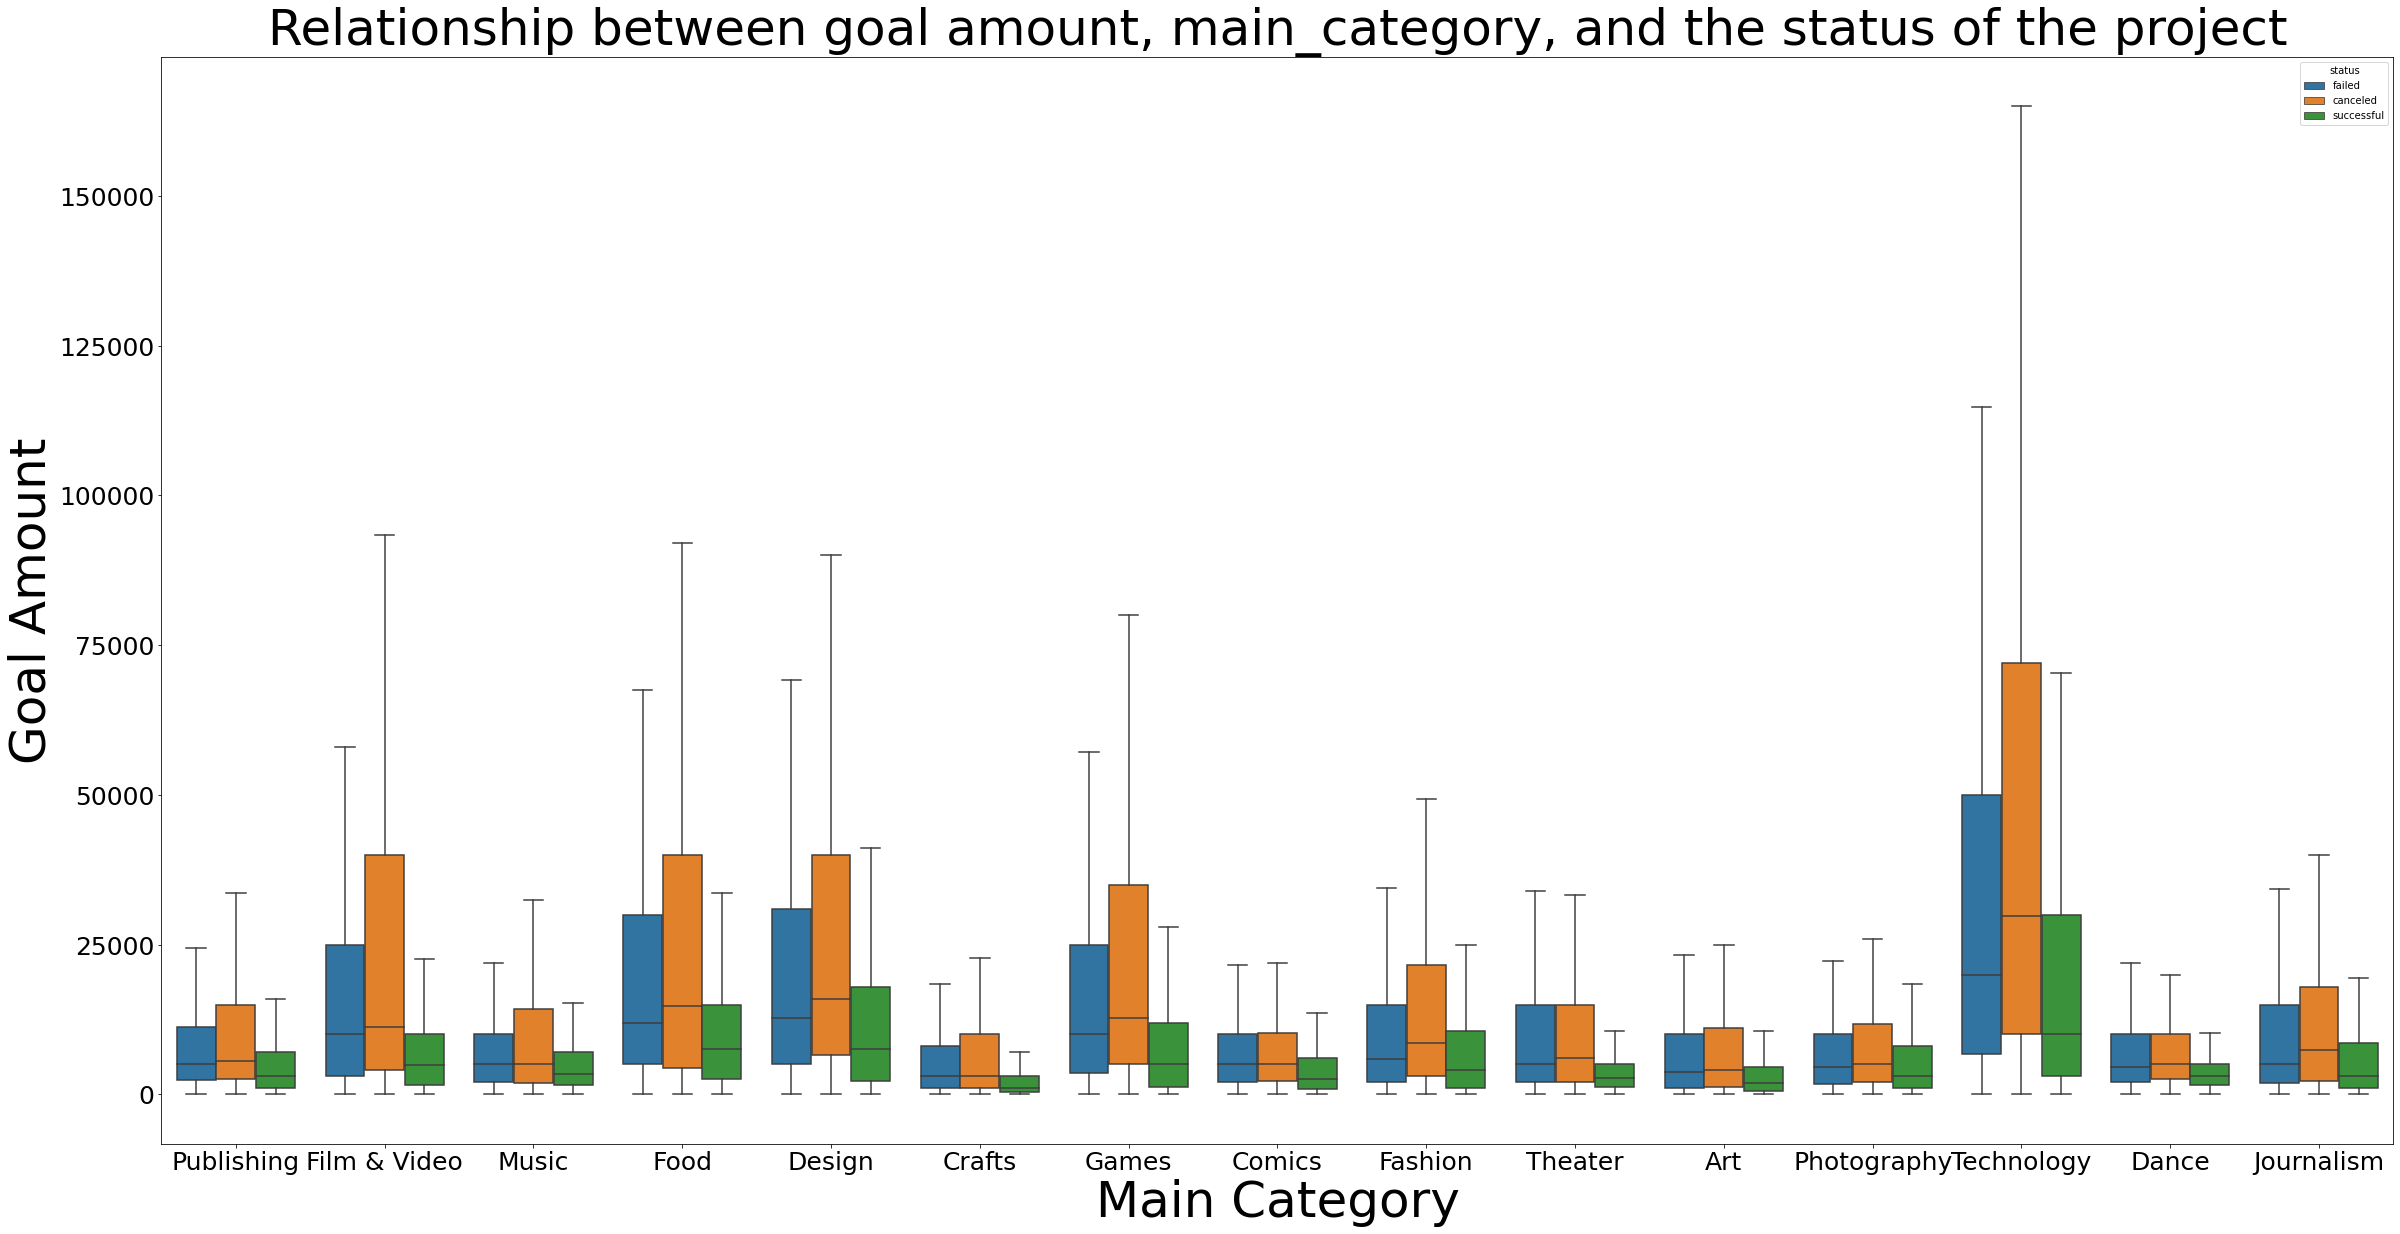

In [92]:
plt.figure(figsize= (40,20))
sns.boxplot(x= 'main_category', y= 'usd_goal', hue= 'status', data = df_ks, showfliers = False)
plt.xlabel('Main Category', fontsize = 50)
plt.ylabel('Goal Amount', fontsize = 50)
plt.title('Relationship between goal amount, main_category, and the status of the project', fontsize = 50)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

These two boxplots indicate that higher the goal amount, higher the likelihood of failure across countries and categories. However, lower goal amount may not be associated with the likelihood of success. 

## Data Pre-processing 
In order to move forward with my hypothesis testing, I will have to do some data pre-processing here. 

1. First, I will have to make the categorical variables numeric. 

In [212]:
# First Categorical Variable: Status
df_ks["status"] = df_ks["status"].replace(["canceled"], "failed")


In [213]:
df_ks['status'].unique()


array(['failed', 'successful'], dtype=object)

(array([0, 1]), [Text(0, 0, 'failed'), Text(1, 0, 'successful')])

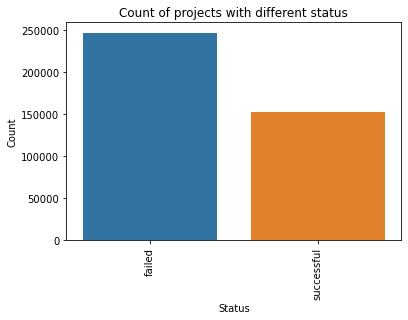

In [214]:
sns.countplot(x = df_ks['status'], data = df_ks)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of projects with different status')
plt.xticks(rotation=90)

In [215]:
df_ks.head()

,id,name,sub_category,main_category,currency,deadline,launched,status,country,usd_pledged,usd_goal,duration,launched_dt,deadline_dt,launched_year,deadline_year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,0.0,1533.95,58,2015-08-11 12:12:28,2015-10-09,2015,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,2421.0,30000.00,59,2017-09-02 04:43:57,2017-11-01,2017,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,220.0,45000.00,44,2013-01-12 00:20:50,2013-02-26,2013,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,1.0,5000.00,29,2012-03-17 03:24:11,2012-04-16,2012,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,failed,US,1283.0,19500.00,55,2015-07-04 08:35:03,2015-08-29,2015,2015


In [123]:
df_ks_num = pd.get_dummies(df_ks, columns = ['status'], drop_first=True, prefix = 'Num')
df_ks_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399168 entries, 0 to 192542
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              399168 non-null  int64         
 1   name            399165 non-null  object        
 2   sub_category    399168 non-null  object        
 3   main_category   399168 non-null  object        
 4   currency        399168 non-null  object        
 5   deadline        399168 non-null  object        
 6   launched        399168 non-null  object        
 7   country         399168 non-null  object        
 8   usd_pledged     399168 non-null  float64       
 9   usd_goal        399168 non-null  float64       
 10  duration        399168 non-null  int64         
 11  launched_dt     399168 non-null  datetime64[ns]
 12  deadline_dt     399168 non-null  datetime64[ns]
 13  launched_year   399168 non-null  int64         
 14  deadline_year   399168 non-null  int

### Masking: 
We know that a majority of the projects are in the US with GB, CA, and AU coming behind. The rest of the countries have far too less projects to be of analytical importance. I will now mask the Country variable. 

In [216]:
country_counts = df_ks_num['country'].value_counts()
mask = df_ks_num['country'].isin(country_counts[country_counts < 10000].index)
df_ks_num['country'][mask] = 'Other'

<ipython-input-216-e9cbf95e5a62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ks_num['country'][mask] = 'Other'


In [217]:
df_ks_num['country'].unique()

array(['GB', 'US', 'CA', 'Other'], dtype=object)

In [218]:
#Second Categorical Variable: Country
df_ks_num = pd.get_dummies(df_ks_num, columns = ['country'], drop_first=True, prefix = 'Num')
df_ks_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399168 entries, 0 to 192542
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              399168 non-null  int64         
 1   name            399165 non-null  object        
 2   sub_category    399168 non-null  object        
 3   main_category   399168 non-null  object        
 4   currency        399168 non-null  object        
 5   deadline        399168 non-null  object        
 6   launched        399168 non-null  object        
 7   usd_pledged     399168 non-null  float64       
 8   usd_goal        399168 non-null  float64       
 9   duration        399168 non-null  int64         
 10  launched_dt     399168 non-null  datetime64[ns]
 11  deadline_dt     399168 non-null  datetime64[ns]
 12  launched_year   399168 non-null  int64         
 13  deadline_year   399168 non-null  int64         
 14  status_num      399168 non-null  int


I will now mask the main category column as well because there are a lot of categories that have very few projects to be of analytical importance. 

In [219]:
category_counts = df_ks_num['main_category'].value_counts()
mask = df_ks_num['main_category'].isin(category_counts[category_counts < 20000].index)
df_ks_num['main_category'][mask] = 'Other'

<ipython-input-219-171ba3ef652c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ks_num['main_category'][mask] = 'Other'


In [220]:
#Third categorical variable: Main Category
df_ks_num = pd.get_dummies(df_ks_num, columns = ['main_category'], drop_first=True, prefix = 'Num')
df_ks_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399168 entries, 0 to 192542
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                399168 non-null  int64         
 1   name              399165 non-null  object        
 2   sub_category      399168 non-null  object        
 3   currency          399168 non-null  object        
 4   deadline          399168 non-null  object        
 5   launched          399168 non-null  object        
 6   usd_pledged       399168 non-null  float64       
 7   usd_goal          399168 non-null  float64       
 8   duration          399168 non-null  int64         
 9   launched_dt       399168 non-null  datetime64[ns]
 10  deadline_dt       399168 non-null  datetime64[ns]
 11  launched_year     399168 non-null  int64         
 12  deadline_year     399168 non-null  int64         
 13  status_num        399168 non-null  int64         
 14  stan

### Scaling
Next, I will scale the pledged amount and the goal amount. I will use the standard scaler because I do not want to put a limit to the maximum and minimum values. 

In [116]:
# First variable: Goal Amount 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_ks_num[['usd_goal']])
df_ks_num['stan_goal'] = scaler.transform(df_ks_num[['usd_goal']])

In [117]:
#Second Variable: Pledged Amount 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_ks_num[['usd_pledged']])
df_ks_num['stan_pledged'] = scaler.transform(df_ks_num[['usd_pledged']])

## Hypothesis Testing with Chi-Square

In this data, we are trying to figure out the relationship between categorical independent variables such as country and main category and categorical dependent variable, status of the project. To do hypothesis testing with both independent and dependent variables that are categorical, we use chi-squared test. 

### Relationship 4 and 5: X = Main Category, Country, Y = Status

We start with the null hypothesis that there is no relationship between the main categories (IV) and countries (IV) and status of the project. 

In [221]:
chi2(df_ks_num[['Num_GB', 'Num_US', 'Num_Other', 'Num_Design', 'Num_Fashion', 'Num_Film & Video', 'Num_Food', 'Num_Games', 'Num_Music', 'Num_Other', 'Num_Publishing', 'Num_Technology']], df_ks_num['Num_successful'])

(array([  35.79914719,  163.80598072,  997.97332975,  965.81086216,
          41.57344511, 1168.79417922,   14.2102416 , 1676.03323766,
          83.01194833, 3222.92946294,  997.97332975,  965.81086216,
         296.64460257, 4277.03991145]),
 array([2.18743625e-009, 1.66780950e-037, 4.95212279e-219, 4.85156114e-212,
        1.13524848e-010, 3.69206213e-256, 1.63478332e-004, 0.00000000e+000,
        8.15589123e-020, 0.00000000e+000, 4.95212279e-219, 4.85156114e-212,
        1.77342554e-066, 0.00000000e+000]))

We see that the p-value for all the above categories is 0, which is very low, and therefore we can safely reject the null hypothesis. 

In [222]:
#this is the anova model on usd_goal; however, my IVs and DVs are switched here. 
model = ols('stan_goal ~ C(Num_successful)', data=df_ks_num).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                          sum_sq        df           F        PR(>F)
C(Num_successful)     237.754037       1.0  237.894541  1.173044e-53
Residual           398930.245963  399166.0         NaN           NaN


In [223]:
#anova on usd_pledged
model = ols('stan_pledged ~ C(Num_successful)', data=df_ks_num).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                          sum_sq        df            F  PR(>F)
C(Num_successful)    5264.882286       1.0  5335.225613     0.0
Residual           393903.117714  399166.0          NaN     NaN


In [224]:
#anova on duration
model = ols('duration ~ C(Num_successful)', data=df_ks_num).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                         sum_sq        df            F  PR(>F)
C(Num_successful)  1.048539e+06       1.0  6599.108855     0.0
Residual           6.342387e+07  399166.0          NaN     NaN


The anova test shows that the p-value for the goal amount, the pledged amount and the duration is 0, which shows that we can reject the null hypothesis. I want to triangulate the finding by doing a t-test. 

We are now going to do a t-test to figure out whether there is a significant difference in means between failed and
successful status for the goal amount, pledged amount and the duration. 

Hypothesis testing on goal amount.

In [ ]:
# as the goal amount is so skewed to the lower end, we are going to look at those numbers that is less than 10000.
#df_ks_1 = df_ks_num[df_ks_num['usd_goal'] < 10000]

In [225]:
#t-test for successful - goal
df_ks_successful = df_ks_num[df_ks_num['Num_successful'] == 1]

In [226]:
df_ks_failed = df_ks_num[df_ks_num['Num_successful'] == 0]

In [227]:
usd_goal_successful = df_ks_successful['stan_goal'].to_numpy()

In [228]:
status = df_ks_successful['Num_successful'].to_numpy()

In [229]:
def sampler(array, n):
    return np.random.choice(array, n) #check with replacement

In [230]:
means = []
for _ in range(100):
    usd_sampler_s = sampler(usd_goal_successful, 1000)
    sampler_mean = usd_sampler_s.mean()
    means.append(sampler_mean)


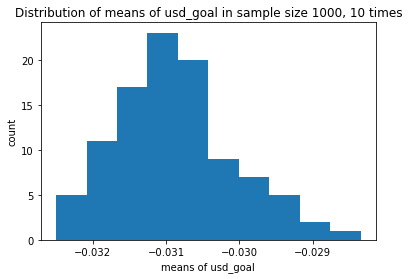

In [231]:
_ = plt.hist(means, bins=10)
_ = plt.xlabel('means of usd_goal')
_ = plt.ylabel('count')
_ = plt.title('Distribution of means of usd_goal in sample size 1000, 10 times')

So, if we take the mean of a 1000 random sample, 100 times we get something similar to a normal distribution. Following the central limit theorem, we can now use t-test to test the hypothesis. 

In [232]:
from scipy import stats
import scipy.stats as scs
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed
from scipy.stats import ttest_ind_from_stats

In [233]:
mean_usd_goal_s = usd_goal_successful.mean()
std_usd_goal_s = usd_goal_successful.std()


In [242]:
#t-test for failed status - goal
usd_goal_failed = df_ks_failed['stan_goal'].to_numpy()

In [243]:
means_failed = []
for _ in range(100):
    usd_sampler_f = sampler(usd_goal_failed, 1000)
    sampler_mean_f = usd_sampler_f.mean()
    means_failed.append(sampler_mean_f)

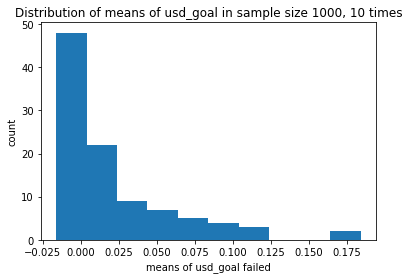

In [244]:
_ = plt.hist(means_failed, bins=10)
_ = plt.xlabel('means of usd_goal failed')
_ = plt.ylabel('count')
_ = plt.title('Distribution of means of usd_goal in sample size 1000, 10 times') #come back to this

So, if we take the mean of a 1000 random sample, 100 times we get something similar to a normal distribution for usd_sample as well. Following the central limit theorem, we can now use t-test to test the hypothesis. 

In [240]:
mean_usd_goal_f = usd_goal_failed.mean()
std_usd_goal_f = usd_goal_failed.std()

In [241]:
ttest_ind_from_stats(mean1=mean_usd_goal_s, std1=std_usd_goal_s, equal_var= False, nobs1=len(usd_goal_successful),
                     mean2=mean_usd_goal_f, std2=std_usd_goal_f, nobs2=len(usd_goal_failed))

Ttest_indResult(statistic=315.120138178634, pvalue=0.0)

The p-value is zero, which indicates that there is a significant difference in the mean of the goal amount of the failed and the successful project status. The t-statistic is good enough, however, not as high as the pledged amount.

### We now repeat the process for the pledged amount as well. 

In [247]:
#df_ks_2 = df_ks[df_ks['usd_pledged'] < 10000]
pledged_successful = df_ks_num[df_ks_num['Num_successful'] == 1]
pledged_failed = df_ks_num[df_ks_num['Num_successful'] == 0]
usd_pledged_successful = pledged_successful['stan_pledged'].to_numpy()


In [248]:
pledged_successful_m = []
for _ in range(100):
    pledged_sampler_s = sampler(usd_pledged_successful, 1000)
    pledged_mean_s = pledged_sampler_s.mean()
    pledged_successful_m.append( pledged_mean_s)

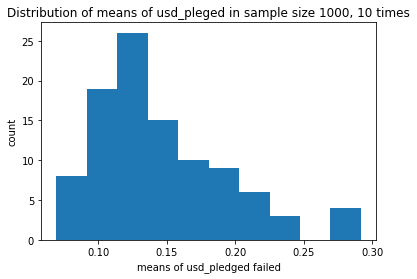

In [249]:
_ = plt.hist(pledged_successful_m, bins=10)
_ = plt.xlabel('means of usd_pledged successful')
_ = plt.ylabel('count')
_ = plt.title('Distribution of means of usd_pleged in sample size 1000, 10 times')

In [250]:
mean_usd_pledged_s = usd_pledged_successful.mean()
std_usd_pledged_s = usd_pledged_successful.std()

In [251]:
usd_pledged_failed = pledged_failed['stan_pledged'].to_numpy()

In [252]:
pledged_failed_m = []
for _ in range(100):
    pledged_sampler_f = sampler(usd_pledged_failed, 1000)
    pledged_mean_f = pledged_sampler_f.mean()
    pledged_failed_m.append(pledged_mean_f)

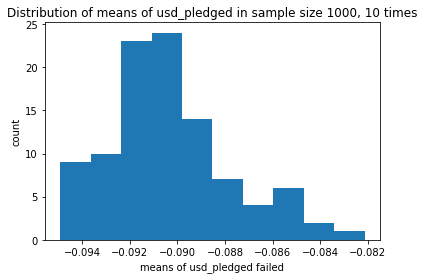

In [253]:
_ = plt.hist(pledged_failed_m, bins=10)
_ = plt.xlabel('means of usd_pledged failed')
_ = plt.ylabel('count')
_ = plt.title('Distribution of means of usd_pledged in sample size 1000, 10 times')

In [254]:
mean_usd_pledged_f = usd_pledged_failed.mean()
std_usd_pledged_f = usd_pledged_failed.std()

In [255]:
ttest_ind_from_stats(mean1=mean_usd_pledged_s, std1=std_usd_pledged_s, equal_var= False, nobs1=len(usd_pledged_successful),
                     mean2=mean_usd_pledged_f, std2=std_usd_pledged_f, nobs2=len(usd_pledged_failed))

Ttest_indResult(statistic=57.550504948636956, pvalue=0.0)

The p-value is zero, which indicates that there is a significant difference in the mean of the pledged amount of the failed and the successful project status. The t-statistic is also very high, which gives a greater evidence against the null hypothesis. 

### Now we do a t-test of duration and status. 

In [256]:
duration_successful = df_ks_num[df_ks_num['Num_successful'] == 0]


In [257]:
duration_array_s = duration_successful['duration'].to_numpy()

In [259]:
duration_failed = df_ks_num[df_ks_num['Num_successful'] == 1]

In [260]:
duration_array_f = duration_successful['duration'].to_numpy()

The histogram above shows that duration is normally distributed. 

In [261]:
mean_duration_s = duration_array_s.mean()
std_duration_s = duration_array_s.std()

In [262]:
mean_duration_f = duration_array_f.mean()
std_duration_f = duration_array_f.std()

In [263]:
ttest_ind_from_stats(mean1=mean_duration_s, std1=std_duration_s, equal_var= False, nobs1=len(duration_array_s),
                     mean2=mean_duration_f, std2=std_duration_f, nobs2=len(duration_array_f))

Ttest_indResult(statistic=0.0, pvalue=1.0)

The p-value is one, which is very high and which indicates that there isn't a significant difference in the mean of the duration of the failed and the successful project status. Moreover, the t-statistic is zero which is very low to indicate any evidence against the null hypothesis. 

### Splitting the data into train and test

In [264]:
df_ks_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399168 entries, 0 to 192542
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                399168 non-null  int64         
 1   name              399165 non-null  object        
 2   sub_category      399168 non-null  object        
 3   currency          399168 non-null  object        
 4   deadline          399168 non-null  object        
 5   launched          399168 non-null  object        
 6   usd_pledged       399168 non-null  float64       
 7   usd_goal          399168 non-null  float64       
 8   duration          399168 non-null  int64         
 9   launched_dt       399168 non-null  datetime64[ns]
 10  deadline_dt       399168 non-null  datetime64[ns]
 11  launched_year     399168 non-null  int64         
 12  deadline_year     399168 non-null  int64         
 13  status_num        399168 non-null  int64         
 14  stan

In [269]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
features = ['id', 'name', 'duration', 'stan_goal', 'stan_pledged', 'Num_GB', 'Num_Other', 'Num_US', 'Num_Design', 'Num_Fashion','Num_Film & Video', 'Num_Food','Num_Games','Num_Music', 'Num_Other', 'Num_Publishing', 'Num_Technology']
X = df_ks_num[features]
y= df_ks_num['Num_successful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Notes

In [ ]:
# from matplotlib.colors import ListedColormap
# pd.set_option('display.width', 500)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.notebook_repr_html', True)
# import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")

# c0=sns.color_palette()[0]
# c1=sns.color_palette()[1]
# c2=sns.color_palette()[2]

# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
# cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
# cm = plt.cm.RdBu
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [ ]:
# def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
#                 cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
#     h = .02
#     X=np.concatenate((Xtr, Xte))
#     x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
#     y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
#                          np.linspace(y_min, y_max, 100))

#     #plt.figure(figsize=(10,6))
#     if zfunc:
#         p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
#         p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#         Z=zfunc(p0, p1)
#     else:
#         Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     ZZ = Z.reshape(xx.shape)
#     if mesh:
#         plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
#     if predicted:
#         showtr = clf.predict(Xtr)
#         showte = clf.predict(Xte)
#     else:
#         showtr = ytr
#         showte = yte
#     ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
#                s=psize, alpha=alpha,edgecolor="k")
#     # and testing points
#     ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
#                alpha=alpha, marker="s", s=psize+10)
#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     return ax,xx,yy

In [ ]:
# from sklearn.decomposition import PCA 

# pca = PCA(n_components = 2)
# X_pca = pca.fit_transform(X)

In [ ]:
# X_pca.shape

In [ ]:
# X_trainp, X_testp, y_trainp, y_testp = train_test_split(X_pca, y, test_size=.2, random_state=1)

In [ ]:
# lr_pca = LogisticRegression()
# logit_pca = lr_pca.fit(X_trainp, y_trainp)
# y_pred_lr_pca = logit_pca.predict(X_testp)

# ac_lr = accuracy_score(y_testp, y_pred_lr_pca)

# f1_lr = f1_score(y_testp, y_pred_lr_pca, average='weighted')


# print('Logistic Regression: Accuracy=%.3f' % (ac_lr))

# print('Logistic Regression: f1-score=%.3f' % (f1_lr))
# #model.predict_proba(X_test)

In [ ]:
# variance = pca.explained_variance_ratio_

# # Plot() it 
# plt.plot(range(len(variance)), variance)

# # Label the axes
# plt.xlabel("Number of Components")
# plt.ylabel("Proportion of Variance Explained")

In [ ]:
# import plotly.express as px
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix(
#     X_pca,
#     labels=labels,
#     dimensions=range(2),
#     color = y
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()

In [ ]:
# plt.figure()
# ax = plt.gca()
# points_plot(ax, X_trainp, X_testp, y_trainp, y_testp, lr_pca, mesh=True, colorscale=cmap_light, 
#                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False)